# Проект по построению модели предсказания рекомендаций по дополнительной лабораторной диагностике с tkinter

## Введение

### Цели, задачи и инструменты реализации проекта

**Вводные данные проекта:**

Необходимо подготовить модель машинного обучения для клинико-диагностической лаборатории, предоставляющей весь спектр медицинских анализов. 

Модель должна предсказать какие дополнительные исследования необходимо выполнить, если в текущих результатах анализов пациента имеются отклонения от нормы (выше или ниже нормы референсных значений лаборатории). Для обучения и предсказания будем использовать обезличенные данные с результатами анализов за период с 2019 по 2022 гг. с указанием отклонений в конкретных медицинских анализах (далее тестах). 

**Целью проекта** является построение модели предсказания рекомендаций по дополнительным тестам, которые необходимы для дальнейшей диагностики или лечения. Это позволит повысить прибыль лаборатории за счет прохождения пациентами дополнительных обследований, а также выявить отклонения на ранних стадиях заболеваний - сахарного диабета, анемии, тромбоза, болезни почек, сердца и печени. 


**Этапы проекта:**
1. Провести предобработку данных и подготовить их к построению модели
2. Обучить и оценить результаты нескольких моделей
3. Осуществить подбор параметров для лучших моделей и выбрать одну для тестирования
4. Протестировать модель и сравнить результаты с константной моделью
5. Сделать выводы по результатам проекта

**Для работы над проектом будут использоваться следующие библиотеки**:

- для анализа и обработки данных:
    - *pandas*
    - *numpy*
    - *phik (корреляция)* 
    
    
- для визуализации данных:
    - *seaborn*
    - *matplotlib*
    
    
- для построения и оценки моделей ML:
    - *sklearn*

### Экспертные рекомендательные алгоритмы по дополнительной лабораторной диагностике

От экспертов (сотрудников) медицинской лаборатории получены следующие алгоритмы рекомендаций по дополнительной диагностике пациентов с определенными отклонениями в результатах анализов:

#### Алгоритм диагностики сахарного диабета/гипогликемии

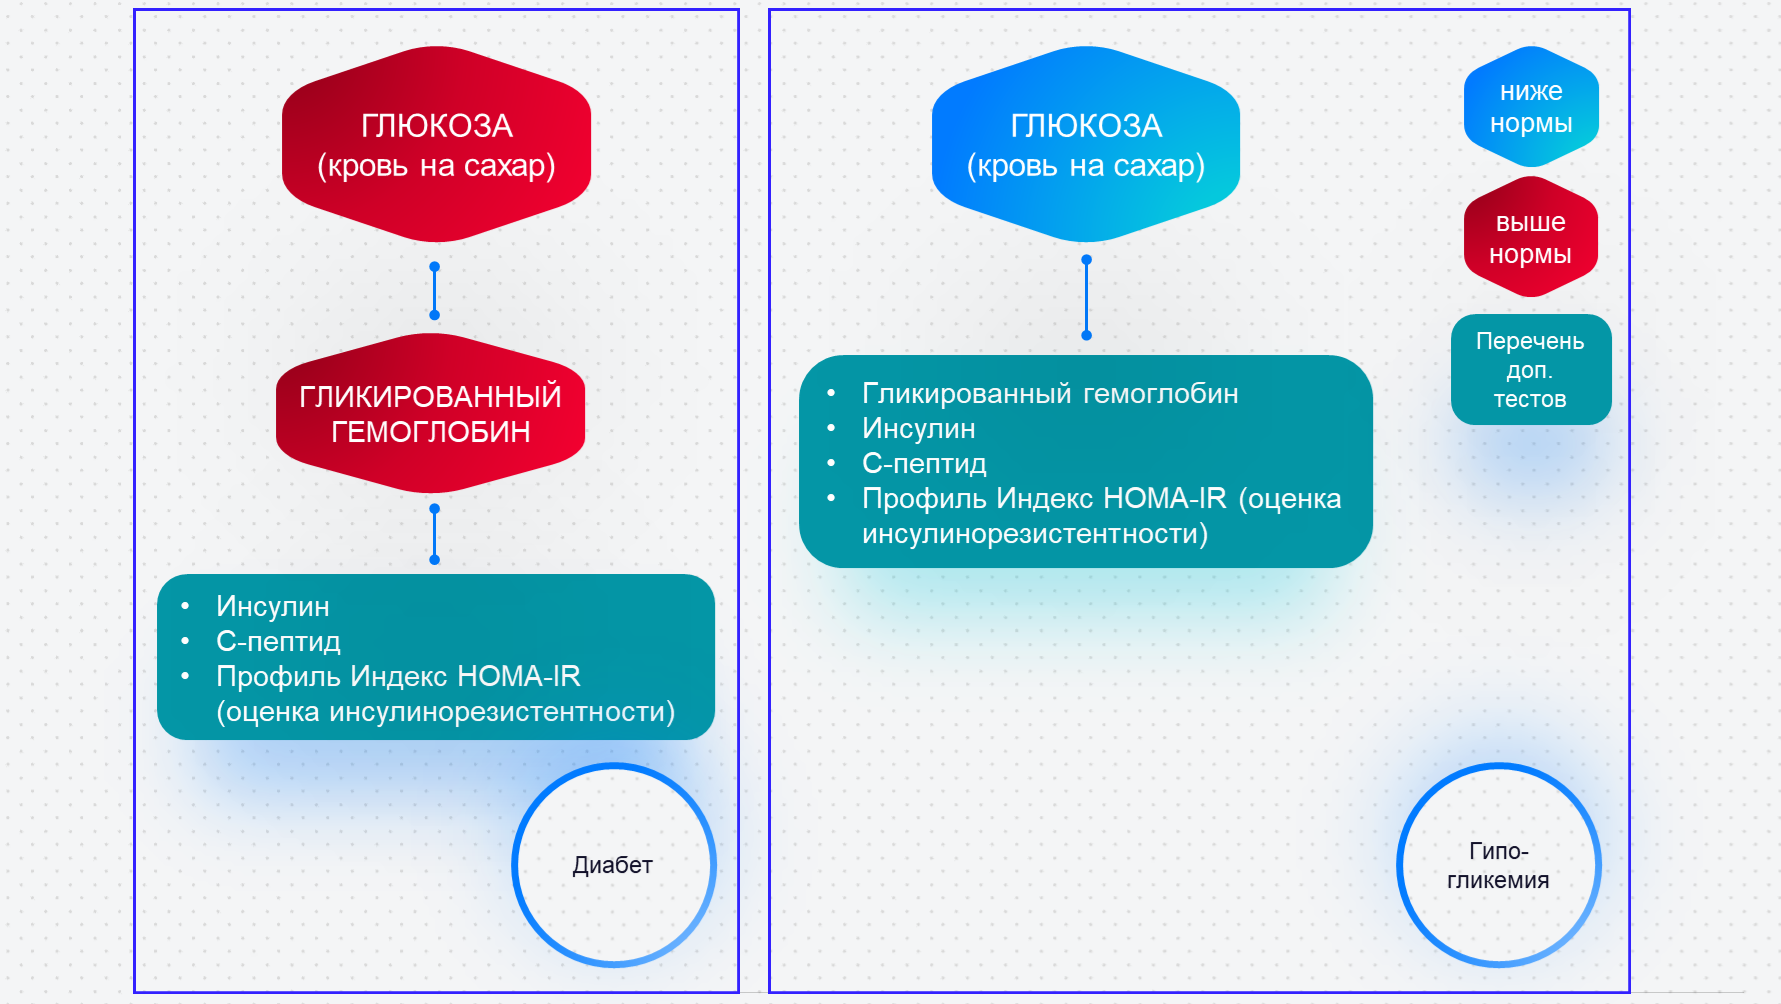

#### Алгоритм диагностики железодефицитных состояний (анемии) и тромбоза

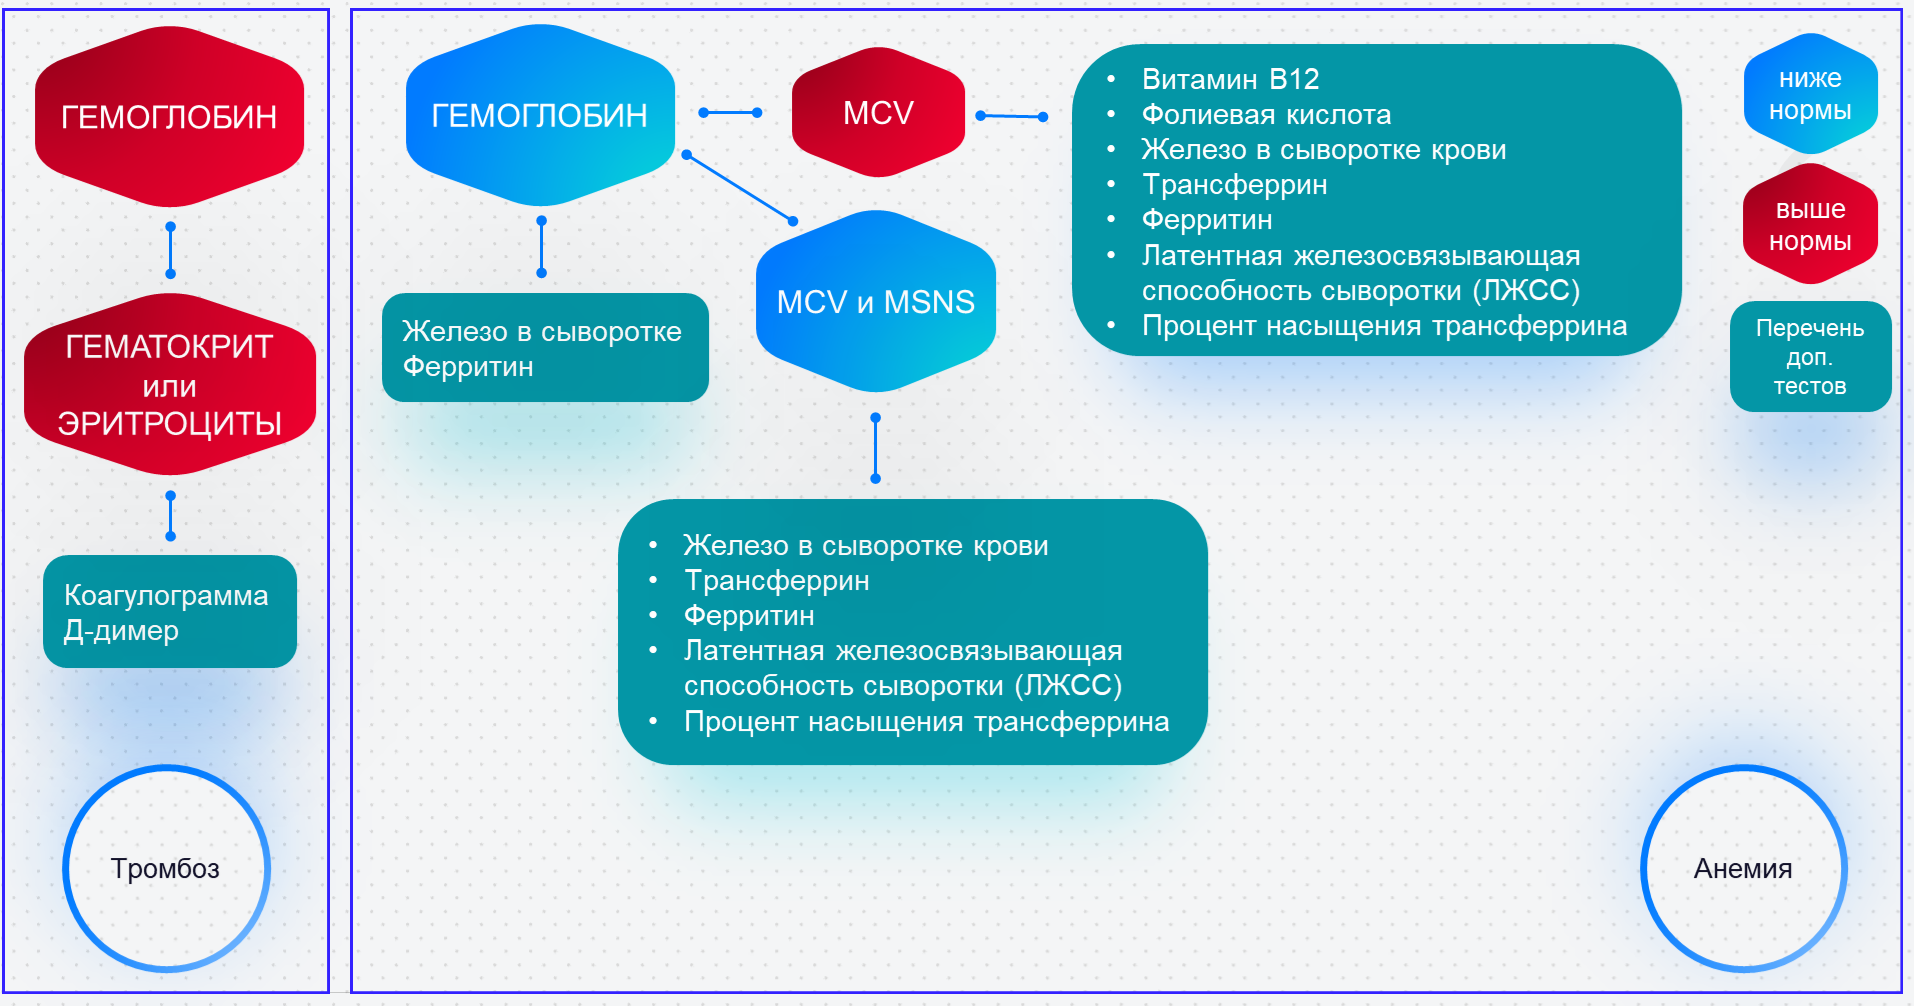

#### Алгоритм диагностики отклонений работы печени, сердца и почек

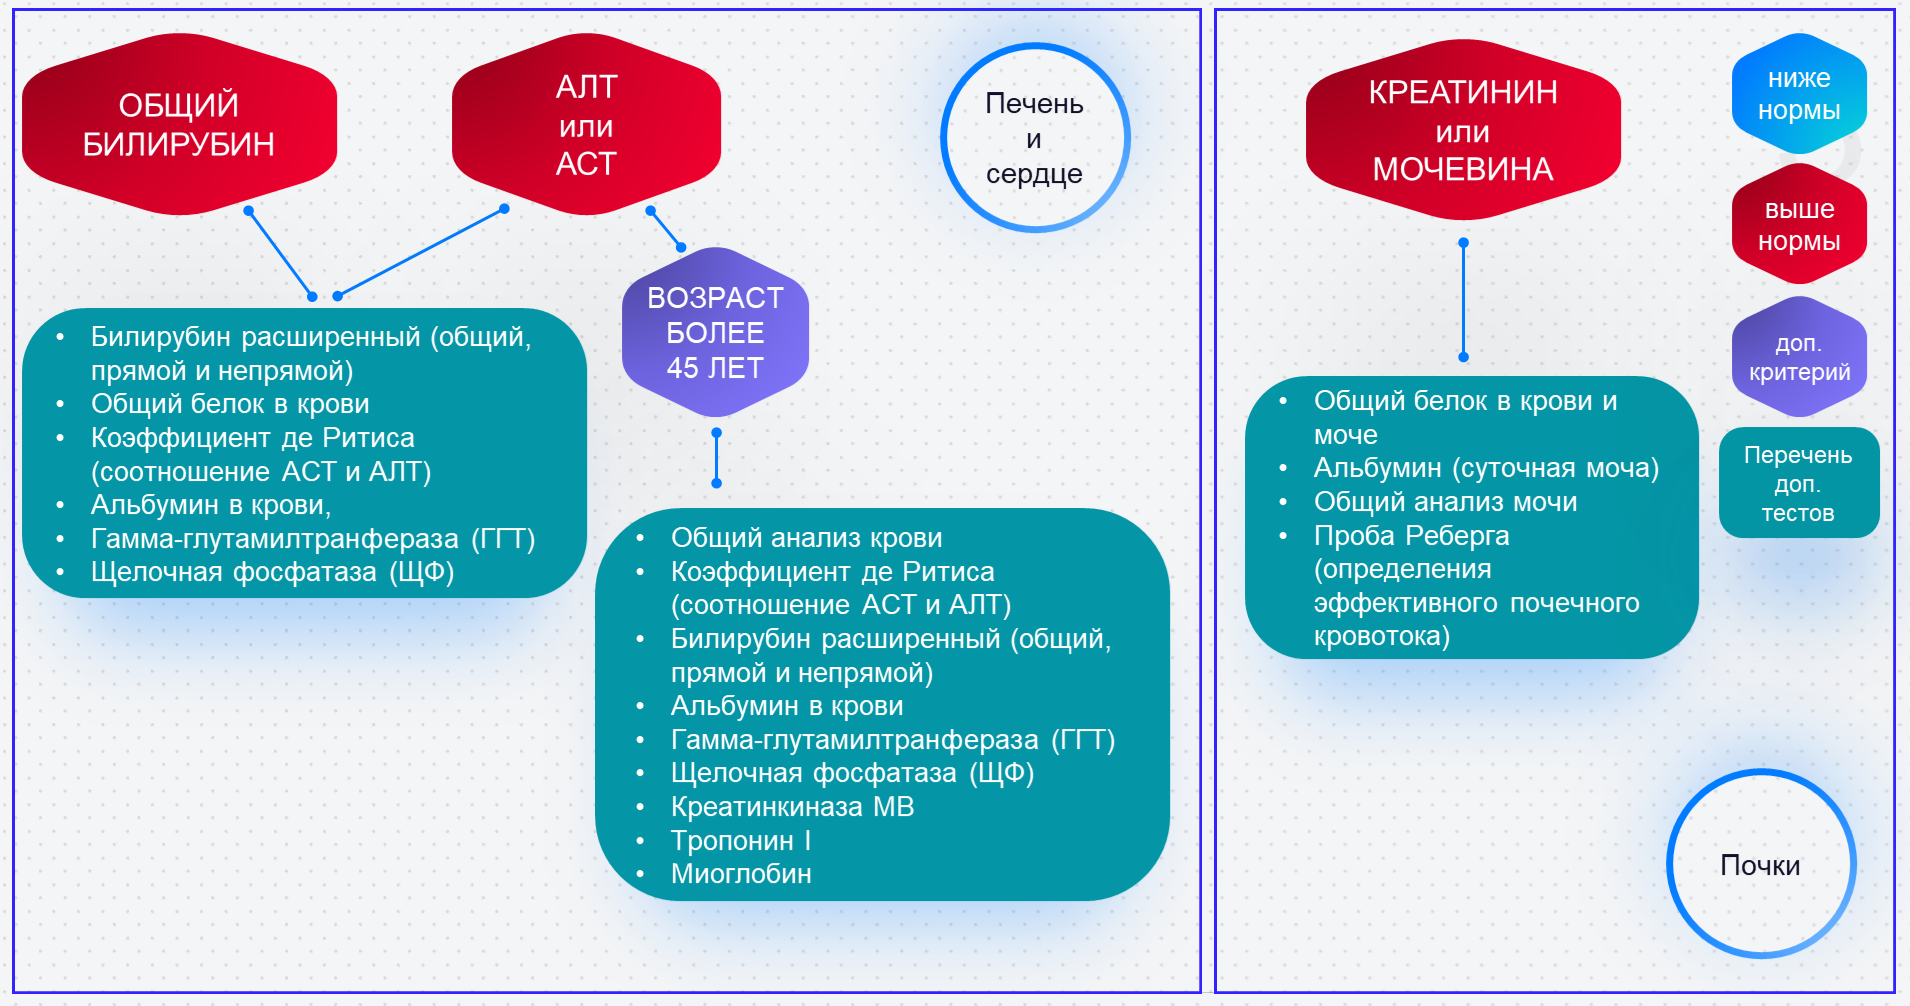

## Подготовка данных

In [1]:
# для работы с данными (предобработка, исследовательский анализ)
import pandas as pd
import numpy as np
import phik
from phik.report import plot_correlation_matrix
from phik import report

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# для машинного обучения
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

# для GUI
import customtkinter
import tkinter
import joblib as jbl

### Загрузка данных

В ходе загрузки данных будут выполнены следующие шаги:
- загружен файл с данными из excel (получены из ЛИС Альфа-Лаб);
- загружен справочник с транслитом мед. тестов;
- приведение наименования столбцов (признаков) и строк (объектов) в удобный формат для анализа (транслит).

In [2]:
# импортируем файл с данными для анализа
file = '2019-2022_копия.xlsx'
xl = pd.ExcelFile(file)

# посмотрим название книг файла excel
print(xl.sheet_names)

# загрузим данные как датафрейм 
df1 = xl.parse('Лабораторная информационная сис', header=None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df1.head())

['Лабораторная информационная сис']
                              0         1                     2   \
0                       Название  Название              Название   
1  Попадание результатов в норму       NaN                   NaN   
2                       Пациенты       Пол  Возрастная категория   
3                            NaN       NaN                   NaN   
4                          12765         Ж      от  20 до 25 лет   

                             3                             4   \
0  Аланинаминотрансфераза (АЛТ)  Аланинаминотрансфераза (АЛТ)   
1           Значение выше нормы           Значение ниже нормы   
2                    Количество                    Количество   
3                      Значение                      Значение   
4                             0                             0   

                               5                    6                    7   \
0  Аспартатаминотрансфераза (АСТ)      Билирубин общий      Билирубин общий   
1     

Для того, чтобы получить столбец с указанием результата (выше нормы или ниже нормы) и наименованием теста, выполним следующие действия:
1. Загрузим справочник с указанием краткого наименования тестов в формате транслита
2. Объединим столбцы с указанием результата (соответствие нормы) и тестов

In [3]:
# импортируем справочник с транслитом тестов
file_2 = 'Показатели для выгрузки.xlsx'
xl_2 = pd.ExcelFile(file_2)
print(xl_2.sheet_names)
df2 = xl_2.parse('Лист2')
print(df2.head())

['Лист1', 'алгоритм', 'проверка для выгрузки', 'транслит', 'Лист2']
                   как в выгрузке         строчные  упрощенные  \
0    Аланинаминотрансфераза (АЛТ)              алт         NaN   
1  Аспартатаминотрансфераза (АСТ)              аст         NaN   
2                 Билирубин общий  билирубин_общий         NaN   
3                      Гематокрит       гематокрит         NaN   
4                      Гемоглобин       гемоглобин         NaN   

            транслит  
0                alt  
1                ast  
2  bilirubin_obschiy  
3         gematokrit  
4         gemoglobin  


In [4]:
df2 = df2.drop(['строчные', 'упрощенные'], axis=1)

In [5]:
# установим первый столбец в качестве индекса
df2 = df2.set_index('как в выгрузке')
display(df2)

,транслит
как в выгрузке,
Аланинаминотрансфераза (АЛТ),alt
Аспартатаминотрансфераза (АСТ),ast
Билирубин общий,bilirubin_obschiy
Гематокрит,gematokrit
Гемоглобин,gemoglobin
Гликированный гемоглобин А1с,glik_gemoglobin
Глюкоза,glyukoza
Инсулин,insulin
Кальций общий,kaltsiy_obschiy


In [6]:
# преобразуем данные в словарь
df2_dict = df2.to_dict()
df2_dict_values = df2_dict['транслит']
df2_dict_values

{'Аланинаминотрансфераза (АЛТ)': 'alt',
 'Аспартатаминотрансфераза (АСТ)': 'ast',
 'Билирубин общий': 'bilirubin_obschiy',
 'Гематокрит': 'gematokrit',
 'Гемоглобин': 'gemoglobin',
 'Гликированный гемоглобин А1с': 'glik_gemoglobin',
 'Глюкоза': 'glyukoza',
 'Инсулин': 'insulin',
 'Кальций общий': 'kaltsiy_obschiy',
 'Креатинин': 'kreatinin',
 'Мочевина': 'mochevina',
 'Общий белок': 'belok_obschiy',
 'Отн.ширина распред.эритр.по объему (RDW)': 'rdw',
 'СОЭ': 'soe',
 'Среднее содержание гемоглобина в эритроците (МСН)': 'msn',
 'Средний объем эритроцитов (MCV)': 'mcv',
 'Средняя концентрация Hb в эритроцитах (МСНС)': 'msns',
 'Фруктозамин': 'fruktozamin',
 'Щелочная фосфатаза': 'schelochnaya_fosfataza',
 'Эритроциты': 'eritrotsity',
 'C-пептид': 's_peptid',
 'Альбумин': 'albumin',
 'Билирубин непрямой': 'bilirubin_nepryamoy',
 'Билирубин прямой': 'bilirubin_pryamoy',
 'Витамин В12 (цианкобаламин)': 'vitamin_b12',
 'Витамин В9 (фолиевая кислота)': 'folievaya_kislota',
 'Гамма-глутамилтран

In [7]:
# заменяем названия анализов на транслит
for column in range(0,df1.shape[1]):
    if df1[column][0] in df2_dict_values.keys():
        df1[column][0] = df2_dict_values[df1[column][0]]
                
df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,Название,Название,Название,alt,alt,ast,bilirubin_obschiy,bilirubin_obschiy,gematokrit,gematokrit,gemoglobin,gemoglobin,glik_gemoglobin,glik_gemoglobin,glyukoza,glyukoza,insulin,insulin,kaltsiy_obschiy,kaltsiy_obschiy,kreatinin,kreatinin,mochevina,mochevina,belok_obschiy,belok_obschiy,rdw,rdw,soe,msn,msn,mcv,mcv,msns,msns,schelochnaya_fosfataza,schelochnaya_fosfataza,eritrotsity,eritrotsity
1,Попадание результатов в норму,NaN,NaN,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение ниже нормы,Значение выше нормы,Значение ниже нормы
2,Пациенты,Пол,Возрастная категория,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество
3,NaN,NaN,NaN,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение
4,12765,Ж,от 20 до 25 лет,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0


In [8]:
df1.loc[1][:].unique()
dict_norm = {'Значение в норме': 'norm', 'Значение выше нормы': 'high_norm', 'Значение ниже нормы': 'low_norm'}

In [9]:
# заменим на транслит результаты тестов
for column in range(0,df1.shape[1]):
    if df1[column][1] in dict_norm.keys():
        df1[column][1] = dict_norm[df1[column][1]]
                
df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,Название,Название,Название,alt,alt,ast,bilirubin_obschiy,bilirubin_obschiy,gematokrit,gematokrit,gemoglobin,gemoglobin,glik_gemoglobin,glik_gemoglobin,glyukoza,glyukoza,insulin,insulin,kaltsiy_obschiy,kaltsiy_obschiy,kreatinin,kreatinin,mochevina,mochevina,belok_obschiy,belok_obschiy,rdw,rdw,soe,msn,msn,mcv,mcv,msns,msns,schelochnaya_fosfataza,schelochnaya_fosfataza,eritrotsity,eritrotsity
1,Попадание результатов в норму,NaN,NaN,high_norm,low_norm,high_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm
2,Пациенты,Пол,Возрастная категория,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество,Количество
3,NaN,NaN,NaN,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение
4,12765,Ж,от 20 до 25 лет,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0


In [10]:
#объединяем название анализа и попадание в норму
for index in range(0, df1.shape[1]):
    df1.loc[2,index] = str(df1.loc[0,index]) + '_' + str(df1.loc[1,index])
df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,Название,Название,Название,alt,alt,ast,bilirubin_obschiy,bilirubin_obschiy,gematokrit,gematokrit,gemoglobin,gemoglobin,glik_gemoglobin,glik_gemoglobin,glyukoza,glyukoza,insulin,insulin,kaltsiy_obschiy,kaltsiy_obschiy,kreatinin,kreatinin,mochevina,mochevina,belok_obschiy,belok_obschiy,rdw,rdw,soe,msn,msn,mcv,mcv,msns,msns,schelochnaya_fosfataza,schelochnaya_fosfataza,eritrotsity,eritrotsity
1,Попадание результатов в норму,NaN,NaN,high_norm,low_norm,high_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm
2,Название_Попадание результатов в норму,Название_nan,Название_nan,alt_high_norm,alt_low_norm,ast_high_norm,bilirubin_obschiy_high_norm,bilirubin_obschiy_low_norm,gematokrit_high_norm,gematokrit_low_norm,gemoglobin_high_norm,gemoglobin_low_norm,glik_gemoglobin_high_norm,glik_gemoglobin_low_norm,glyukoza_high_norm,glyukoza_low_norm,insulin_high_norm,insulin_low_norm,kaltsiy_obschiy_high_norm,kaltsiy_obschiy_low_norm,kreatinin_high_norm,kreatinin_low_norm,mochevina_high_norm,mochevina_low_norm,belok_obschiy_high_norm,belok_obschiy_low_norm,rdw_high_norm,rdw_low_norm,soe_high_norm,msn_high_norm,msn_low_norm,mcv_high_norm,mcv_low_norm,msns_high_norm,msns_low_norm,schelochnaya_fosfataza_high_norm,schelochnaya_fosfataza_low_norm,eritrotsity_high_norm,eritrotsity_low_norm
3,NaN,NaN,NaN,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение
4,12765,Ж,от 20 до 25 лет,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0


In [11]:
# переименуем столбцы
df1[1][2] = 'gender'
df1[2][2] = 'age_group'
df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,Название,Название,Название,alt,alt,ast,bilirubin_obschiy,bilirubin_obschiy,gematokrit,gematokrit,gemoglobin,gemoglobin,glik_gemoglobin,glik_gemoglobin,glyukoza,glyukoza,insulin,insulin,kaltsiy_obschiy,kaltsiy_obschiy,kreatinin,kreatinin,mochevina,mochevina,belok_obschiy,belok_obschiy,rdw,rdw,soe,msn,msn,mcv,mcv,msns,msns,schelochnaya_fosfataza,schelochnaya_fosfataza,eritrotsity,eritrotsity
1,Попадание результатов в норму,NaN,NaN,high_norm,low_norm,high_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm,high_norm,low_norm
2,Название_Попадание результатов в норму,gender,age_group,alt_high_norm,alt_low_norm,ast_high_norm,bilirubin_obschiy_high_norm,bilirubin_obschiy_low_norm,gematokrit_high_norm,gematokrit_low_norm,gemoglobin_high_norm,gemoglobin_low_norm,glik_gemoglobin_high_norm,glik_gemoglobin_low_norm,glyukoza_high_norm,glyukoza_low_norm,insulin_high_norm,insulin_low_norm,kaltsiy_obschiy_high_norm,kaltsiy_obschiy_low_norm,kreatinin_high_norm,kreatinin_low_norm,mochevina_high_norm,mochevina_low_norm,belok_obschiy_high_norm,belok_obschiy_low_norm,rdw_high_norm,rdw_low_norm,soe_high_norm,msn_high_norm,msn_low_norm,mcv_high_norm,mcv_low_norm,msns_high_norm,msns_low_norm,schelochnaya_fosfataza_high_norm,schelochnaya_fosfataza_low_norm,eritrotsity_high_norm,eritrotsity_low_norm
3,NaN,NaN,NaN,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение,Значение
4,12765,Ж,от 20 до 25 лет,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0


In [12]:
# удалим лишние колонки и строки
df1 = df1.drop(labels = [0,1,3], axis = 0).drop([0], axis=1)

In [13]:
df1.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
2,gender,age_group,alt_high_norm,alt_low_norm,ast_high_norm,bilirubin_obschiy_high_norm,bilirubin_obschiy_low_norm,gematokrit_high_norm,gematokrit_low_norm,gemoglobin_high_norm,gemoglobin_low_norm,glik_gemoglobin_high_norm,glik_gemoglobin_low_norm,glyukoza_high_norm,glyukoza_low_norm,insulin_high_norm,insulin_low_norm,kaltsiy_obschiy_high_norm,kaltsiy_obschiy_low_norm,kreatinin_high_norm,kreatinin_low_norm,mochevina_high_norm,mochevina_low_norm,belok_obschiy_high_norm,belok_obschiy_low_norm,rdw_high_norm,rdw_low_norm,soe_high_norm,msn_high_norm,msn_low_norm,mcv_high_norm,mcv_low_norm,msns_high_norm,msns_low_norm,schelochnaya_fosfataza_high_norm,schelochnaya_fosfataza_low_norm,eritrotsity_high_norm,eritrotsity_low_norm
4,Ж,от 20 до 25 лет,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0
5,М,от 50 до 55 лет,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,М,от 20 до 25 лет,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,М,от 35 до 40 лет,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# присвоим полученные названия заголовку
df1_dict_col = df1.loc[df1.index == 2].to_dict(orient='index')
df1_dict_col_val = df1_dict_col[2] 
df1 = df1.rename(columns=df1_dict_col_val)

In [15]:
# удалим дублиющууся с заголовком строку
df1 = df1.drop(labels = [2])

In [16]:
# заменим обозначение пола на числовые значения
df1 = df1.replace({'gender':{'М':1, 'Ж': 0}})

In [17]:
# создадим словарь упрощенных категорий по возрасту
dict_age = {'от  20 до 25 лет': '20_25','от  50 до 55 лет': '50_55','от  35 до 40 лет': '35_40','от  30 до 35 лет': '30_35', 
            'от  25 до 30 лет': '25_30','от   5 до 10 лет': '5_10','от  40 до 45 лет': '40_45','от  45 до 50 лет': '45_50',
            'от  10 до 15 лет': '10_15','от  65 до 70 лет': '65_70','от  15 до 20 лет': '15_20','от  55 до 60 лет': '55_60',
            'от  70 до 75 лет': '70_75','от   0 до 5 лет': '0_5','от  60 до 65 лет': '60_65','от  75 до 80 лет': '75_80',
            'от  80 до 85 лет': '80_85','от  90 до 95 лет': '90_95','от  85 до 90 лет': '85_90','от  95 до 100 лет':'95_100'}

In [18]:
# заменим категории возраста на упрощенные
df1 = df1.replace({'age_group':dict_age})
df1['age_group'] = df1['age_group'].astype('category')

In [19]:
# заменим количество раз сдачи анализов (одиннаковых) на единицу - нам важен факт фиксации отклонений, а не их количество
for col in df1:
    print(df1[col].unique())

[0 1]
['20_25', '50_55', '35_40', '30_35', '25_30', ..., '75_80', '80_85', '90_95', '85_90', '95_100']
Length: 20
Categories (20, object): ['0_5', '10_15', '15_20', '20_25', ..., '80_85', '85_90', '90_95', '95_100']
[0 2 1 4 5 3 6]
[0 1]
[0 2 1 3 4 5]
[0 1 2 3 6 5]
[0 1 2]
[0 1 2 3 5 4 6]
[1 0 3 2]
[0 1 2 3 4 5 8]
[1 0 3 2 18 10 4 6]
[0 1 2 3 5]
[0 1 2]
[0 1 2 4 3 5 6]
[0 1 2]
[0 1 2 4]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2 5 3]
[0 1 2 3 8]
[0 1 2 5 3]
[0 1 2 7]
[0 1]
[0 1 2 15 3 4]
[1 0 2 3 17 4]
[0 1 2 3 5]
[0 1 2 3 10 6]
[0 1 3 2 4]
[1 0 2 3 4]
[0 1 3 2 4 5 7 6]
[1 0 2 4 3]
[0 1 2]
[1 0 2 3 4]
[0 1 2 4 3 6]
[0 2 1 3]
[0 1 2 3 4]
[0 1 2 3 11]


In [20]:
df1=df1.replace({2:1,3:1,4:1,5:1,6:1,7:1,8:1,10:1,11:1,15:1,17:1,18:1})

In [21]:
for col in df1:
    print(df1[col].unique())

[0 1]
['20_25', '50_55', '35_40', '30_35', '25_30', ..., '75_80', '80_85', '90_95', '85_90', '95_100']
Length: 20
Categories (20, object): ['0_5', '10_15', '15_20', '20_25', ..., '80_85', '85_90', '90_95', '95_100']
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]


**Выводы по итогам загрузки данных:**
- загружена база с отклонениями результатов (выше и ниже нормы) анализов пациентов за 2019-2022гг. по необходимым для формирования алгоритмов диагностики тестов;
- подготовлены признаки (заголовки датафрейма) с указанием мед. теста и отклонения (выше или ниже нормы);
- значения в таблице приведены к виду [0 1], так как нас интересует факт получения, либо не получения отклонений в анализах, а не их количество. Это, в том числе, позволит коректно оценить корреляцию;
- название столбцов (признаков) и строк (объектов) приведены в один формат (транслит).

### Изучение общей информации о данных

В ходе изучения общей информации осуществим следующие шаги:
- проверим типы данных и корректность заголовков;
- проверим данные на отсутствие пропусков.

In [22]:
df1.head()

,gender,age_group,alt_high_norm,alt_low_norm,ast_high_norm,bilirubin_obschiy_high_norm,bilirubin_obschiy_low_norm,gematokrit_high_norm,gematokrit_low_norm,gemoglobin_high_norm,gemoglobin_low_norm,glik_gemoglobin_high_norm,glik_gemoglobin_low_norm,glyukoza_high_norm,glyukoza_low_norm,insulin_high_norm,insulin_low_norm,kaltsiy_obschiy_high_norm,kaltsiy_obschiy_low_norm,kreatinin_high_norm,kreatinin_low_norm,mochevina_high_norm,mochevina_low_norm,belok_obschiy_high_norm,belok_obschiy_low_norm,rdw_high_norm,rdw_low_norm,soe_high_norm,msn_high_norm,msn_low_norm,mcv_high_norm,mcv_low_norm,msns_high_norm,msns_low_norm,schelochnaya_fosfataza_high_norm,schelochnaya_fosfataza_low_norm,eritrotsity_high_norm,eritrotsity_low_norm
4,0,20_25,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0
5,1,50_55,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,1,20_25,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,35_40,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,30_35,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
def info_all(data):
    '''функция оценивает общую информацию о данных'''
    print('-'*50)
    print('Общая информация о данных')
    temp = data.copy() 
    list_c = data.columns
    print(temp.info())
    for col_l in list_c:
        print('-'* 25)
        print(col_l, temp[col_l].sort_values().unique())
        print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

Проверим данные на пропуски.

In [24]:
info_all(df1)

--------------------------------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41795 entries, 4 to 41798
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   gender                            41795 non-null  int64   
 1   age_group                         41795 non-null  category
 2   alt_high_norm                     41795 non-null  int64   
 3   alt_low_norm                      41795 non-null  int64   
 4   ast_high_norm                     41795 non-null  int64   
 5   bilirubin_obschiy_high_norm       41795 non-null  int64   
 6   bilirubin_obschiy_low_norm        41795 non-null  int64   
 7   gematokrit_high_norm              41795 non-null  int64   
 8   gematokrit_low_norm               41795 non-null  int64   
 9   gemoglobin_high_norm              41795 non-null  int64   
 10  gemoglobin_low_norm               41795 n

Пропуски в данных отсутствуют, типы данных указаны верно.

Корреляционный анализ признаков будет проведен в разделе 3.2 исследовательского анализа данных (оценка достоверности экспертных рекомендательных алгоритмов).

### Выводы по результатам подготовки данных к анализу

**В ходе подготовки данных были выполнены следующие задачи:**
- загружена база с отклонениями результатов (выше и ниже нормы) анализов пациентов за 2019-2022гг. по необходимым для диагностики тестов;
- столбцы (признаки) и строки (объекты) приведены к необходимому для обработки формату:
    - наименования в формате транслита;
    - значения признаков (меж. анализы) приведены к формату (отсутствия (0) или наличия (1) отклонений).
- проведена проверка на наличие пропусков в данных (пропуски отсутствуют).

##  Предобработка данных

###  Оценка распределения категориальных признаков

Для более детального ознакомления со структурой данных посмотрим на распределение наших признаков.

In [25]:
def graph_kat(data, data_label1, data_label2=''):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(25, 5))
    axes[0].set_title(data_label1 + ". Кол-во по категориям", fontsize=18)
    sns.countplot(data=df1.sort_values(by=data_label1), x=data_label1, ax=axes[0], palette='pastel')
    if data_label2 != '':
        axes[1].set_title(data_label2 + ". Кол-во по категориям", fontsize=18)
        sns.countplot(data=df1.sort_values(by=data_label2), x=data_label2, ax=axes[1], palette='pastel')
    plt.show()

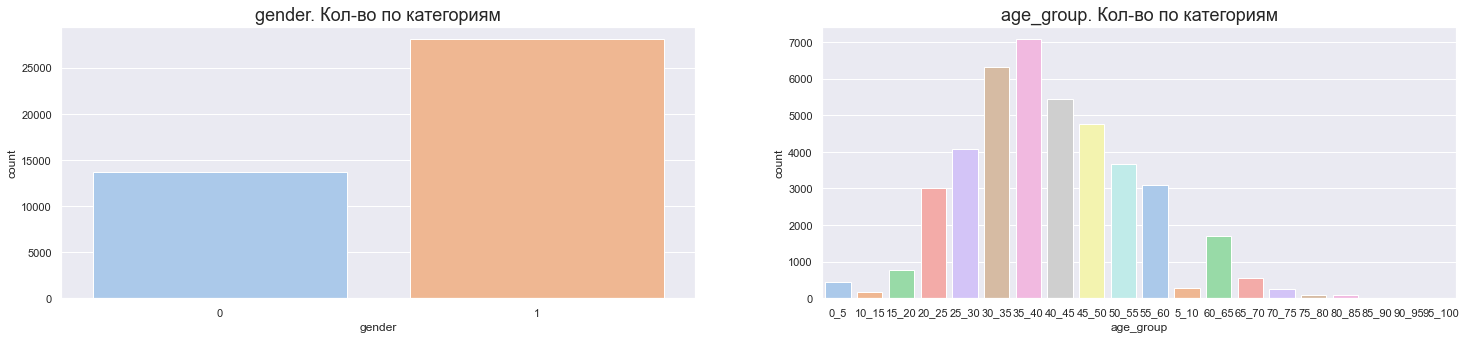

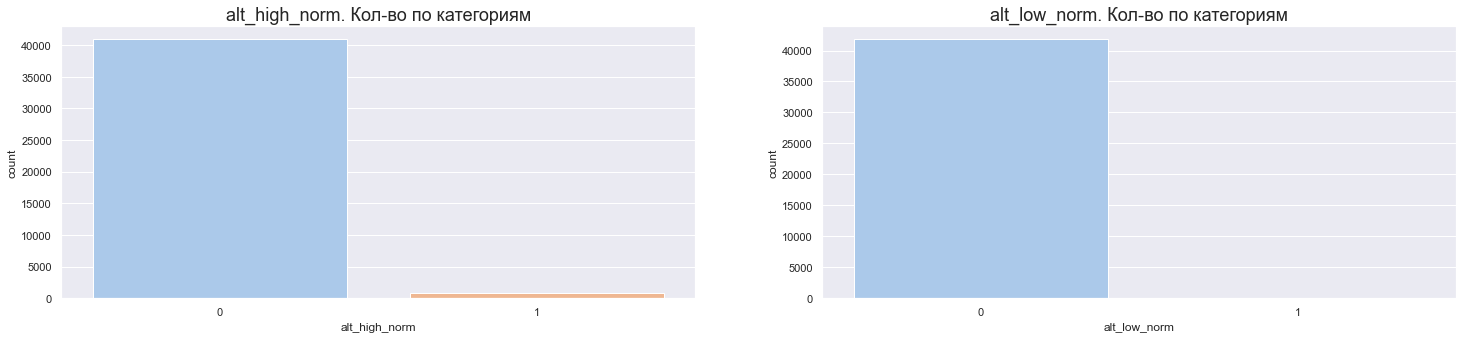

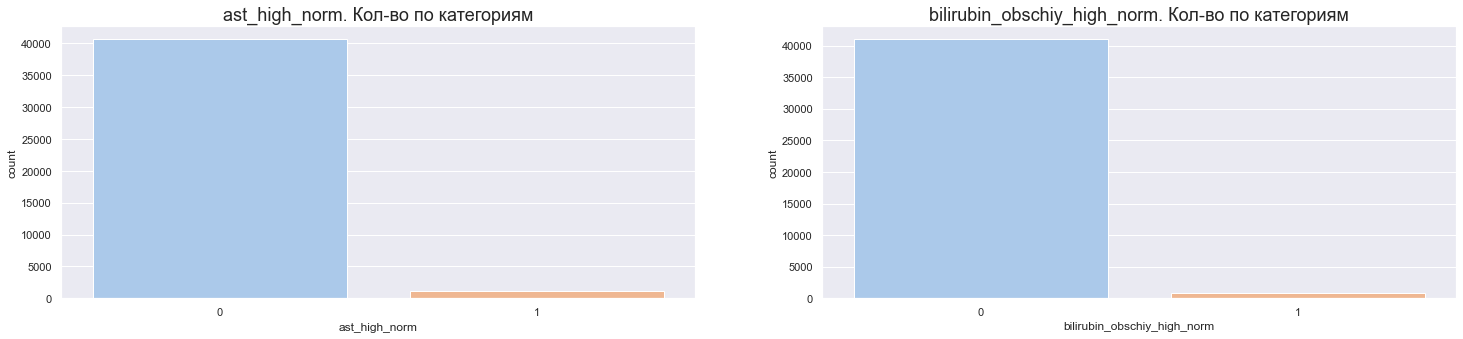

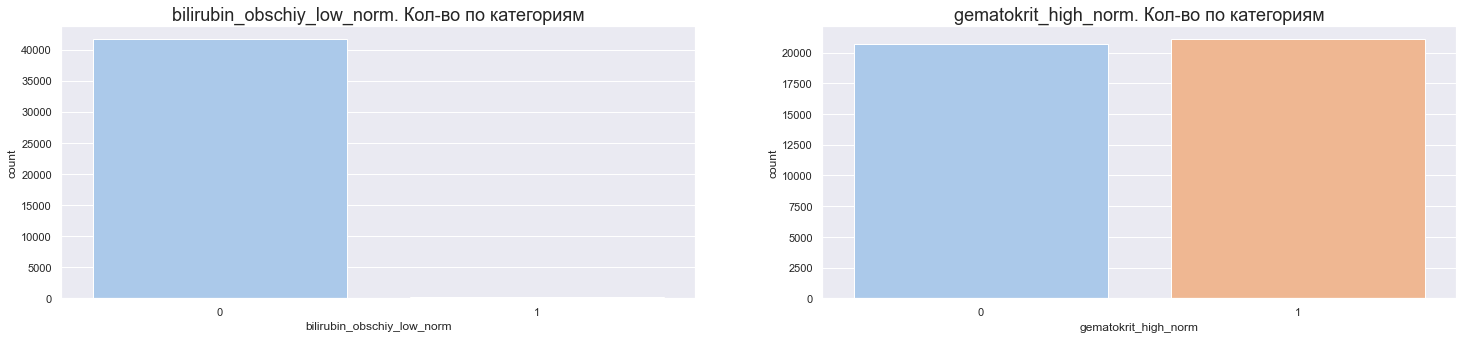

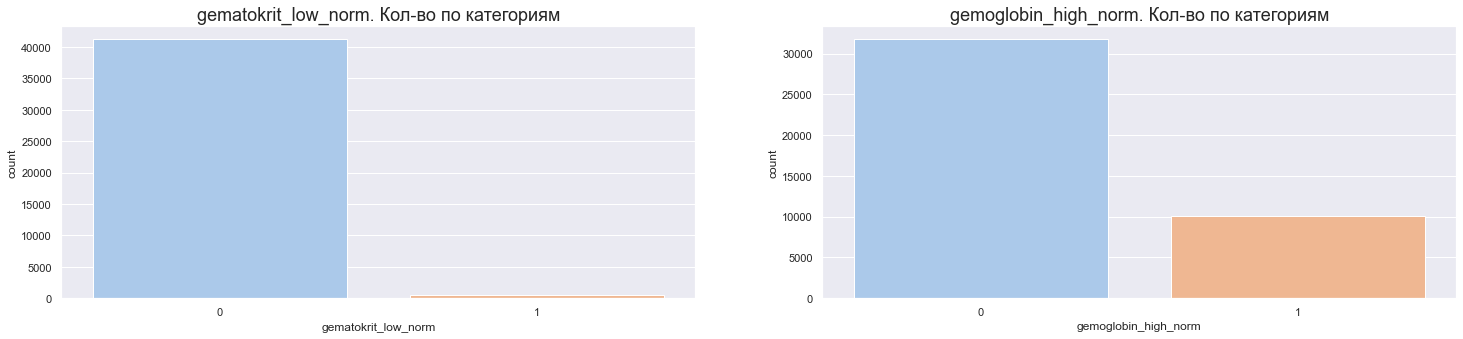

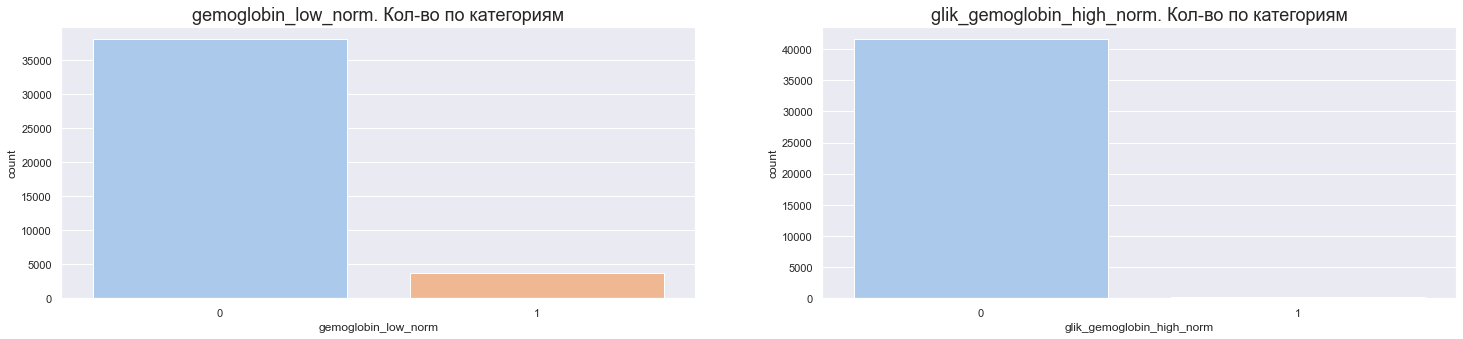

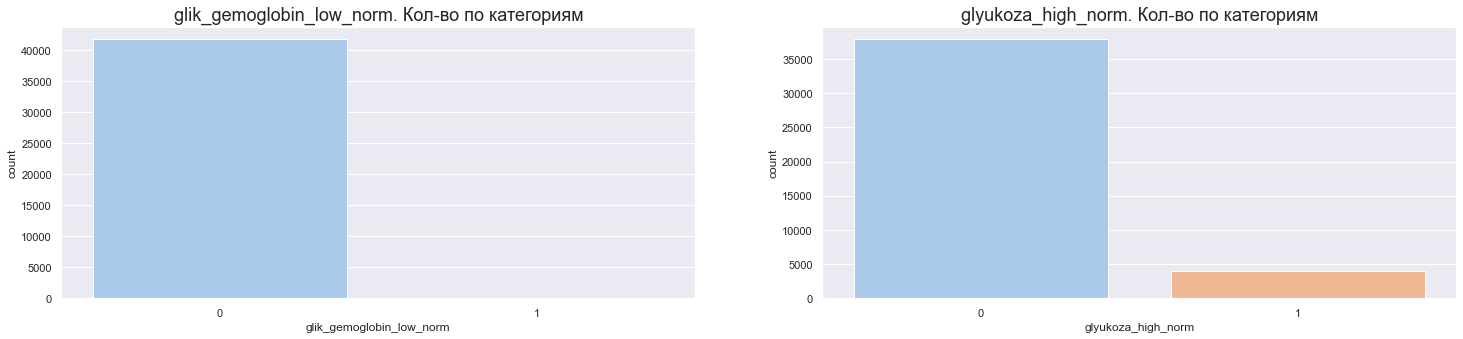

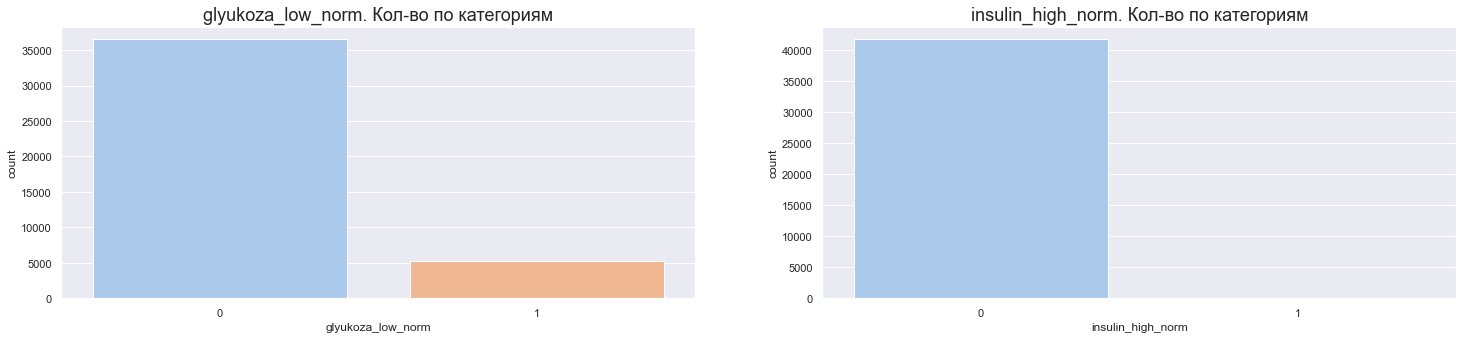

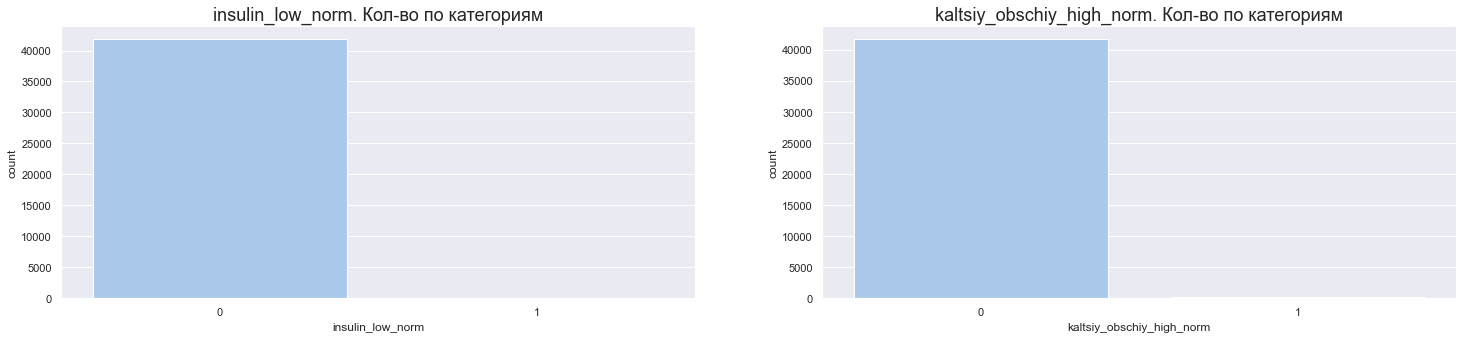

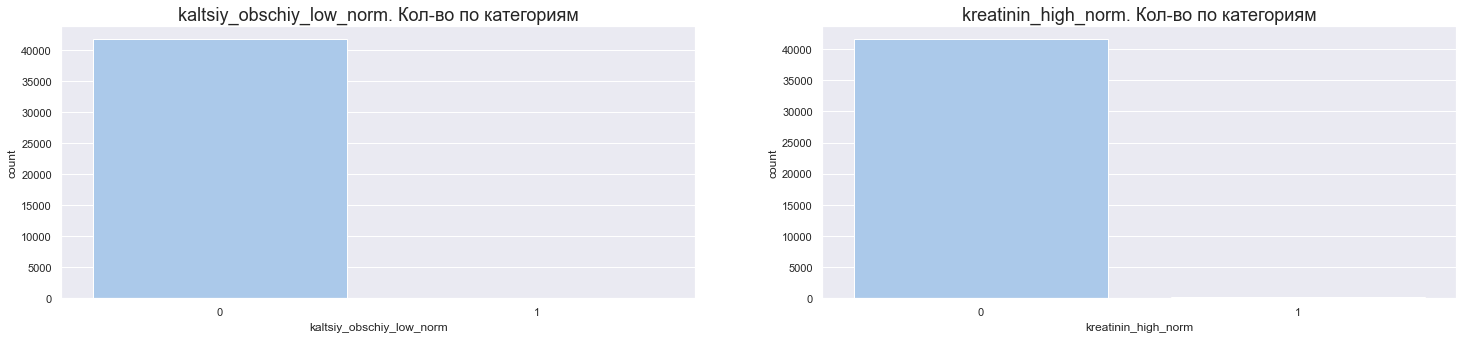

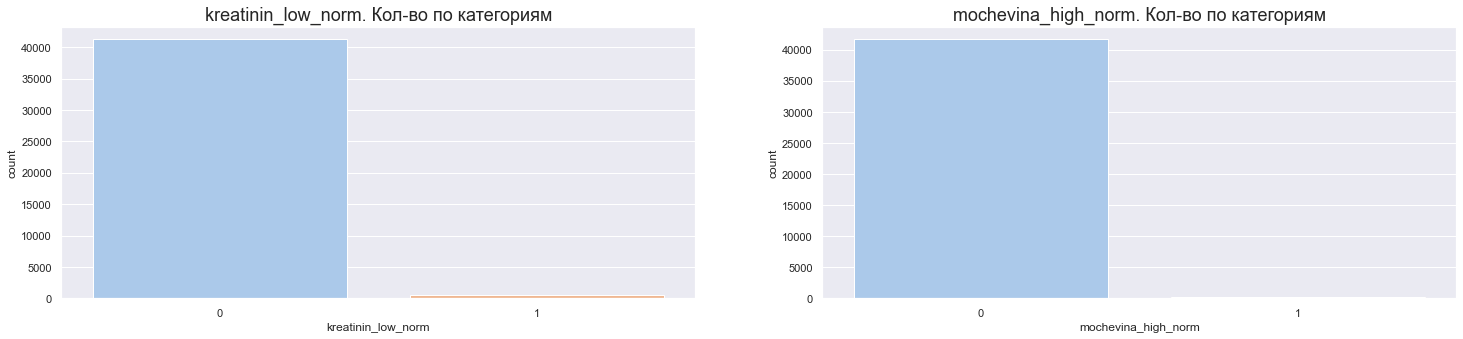

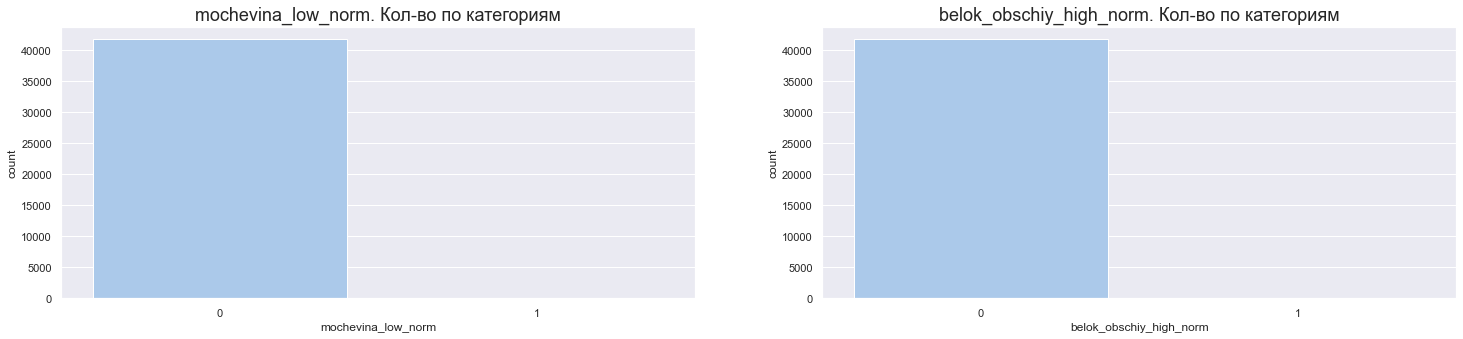

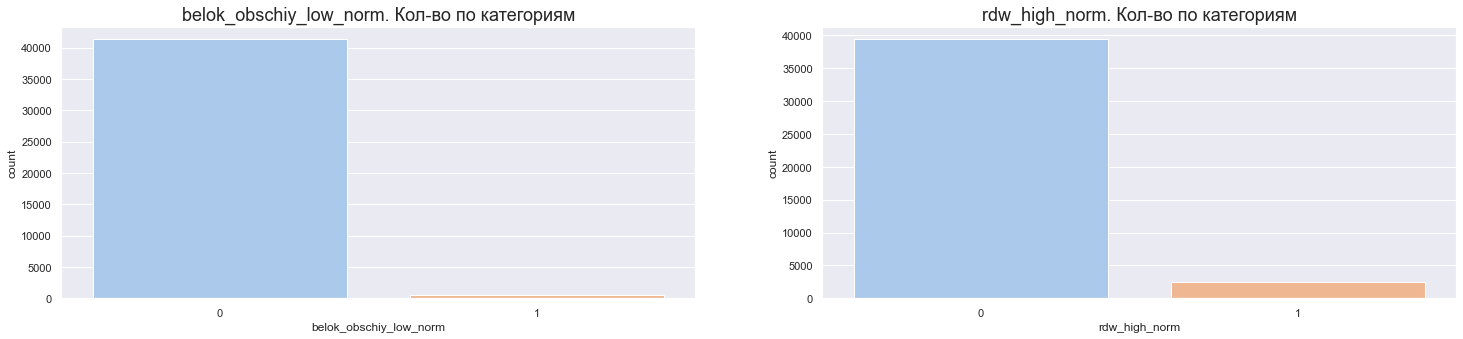

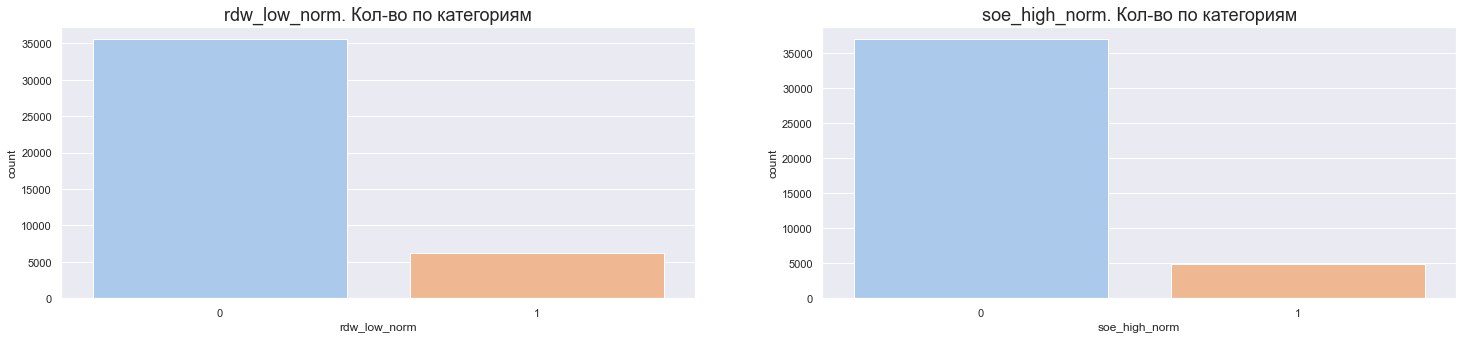

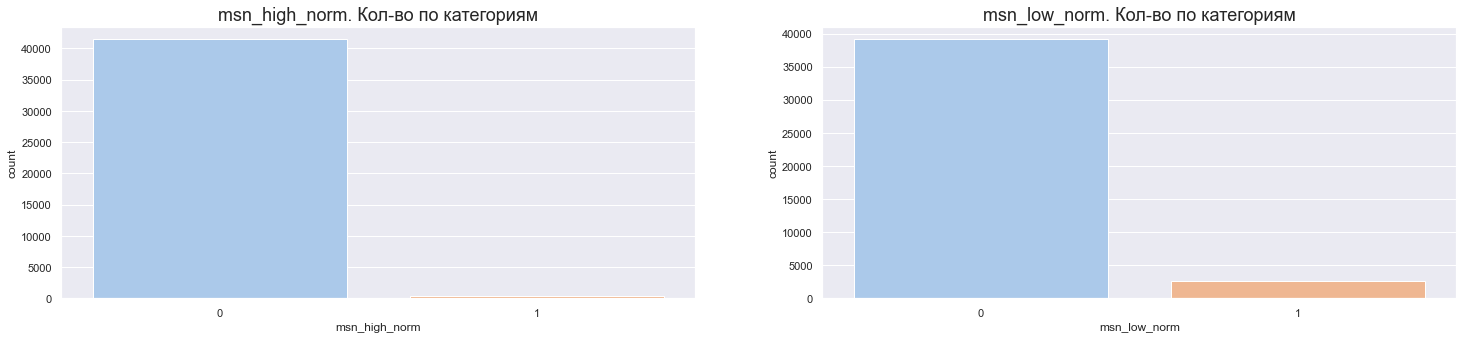

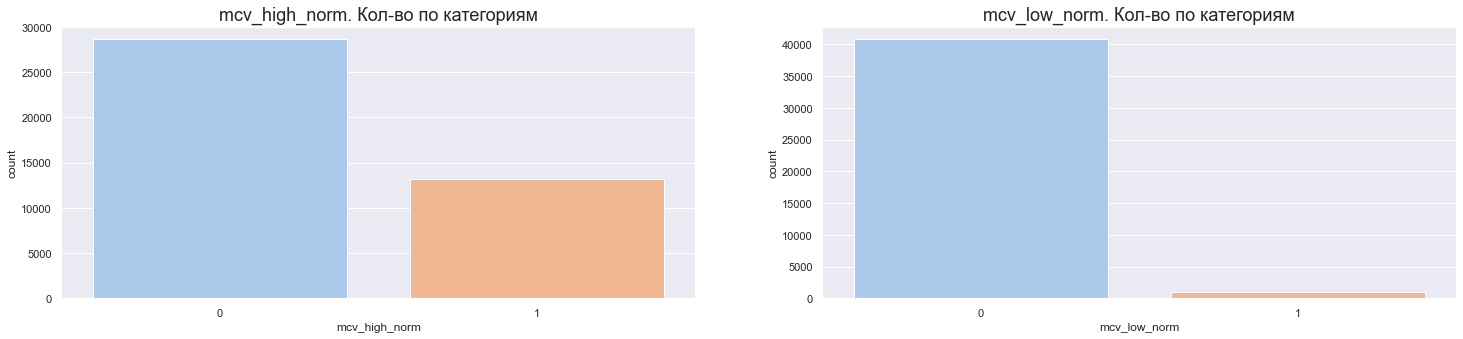

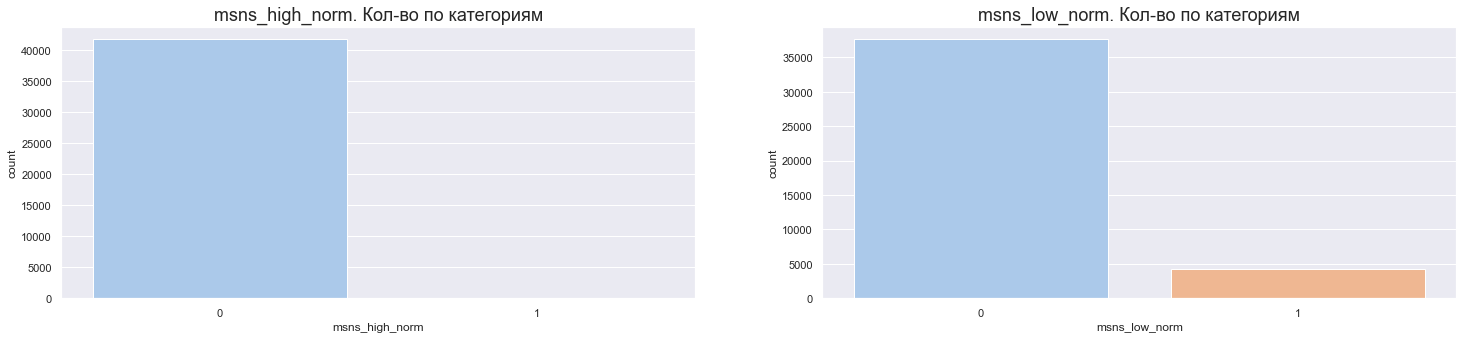

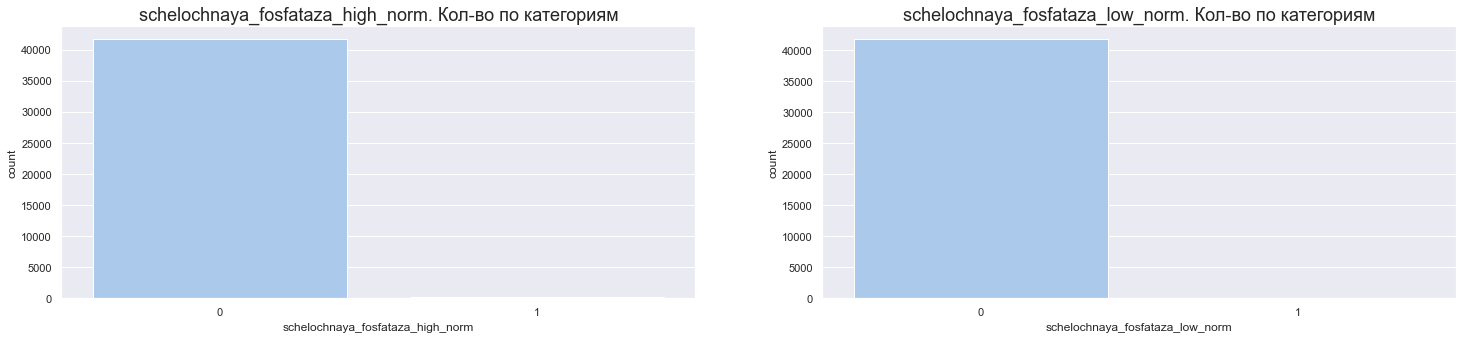

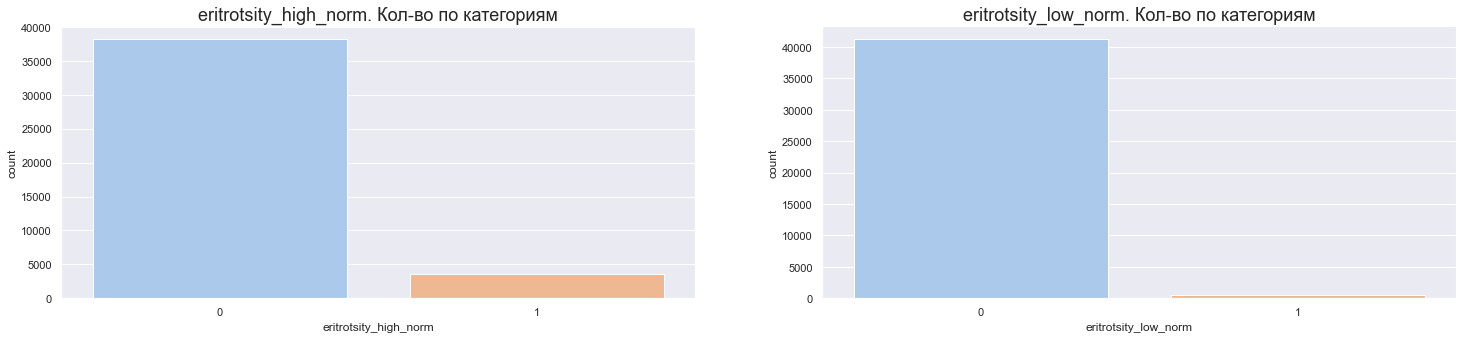

In [26]:
categories = df1.columns.to_list()
for i in range(len(categories)//2):
    graph_kat(df1, categories[2*i], categories[2*i+1])

**Из полученного распределения можно сделать следующие выводы:**
- пол пациентов распределен неравномерно - мужчин в 2 раза больше, чем женщин;
- возраст пациентов стремится к нормальному распределению, пик приходится на 30-40 лет;
- признаки по медицинским тестам (выявлено ли отклонение в анализах), как и ожидалось, распределены неравномерно - отклонений от нормы значительно меньше (исключение составляет только повышеный показатель гематокрит - там отклонения составляют 50% от всех результатов).

При разделении данных на выборки и обучении модели необходимо использовать балансировку классов.

### Оценка достоверности экспертных рекомендательных алгоритмов 

От экспертов (сотрудников) медицинской лаборатории получены алгоритмы рекомендаций по дополнительной диагностике пациентов с определенными отклонениями в результатах анализов.

С целью подтверждения указанных алгоритмов, оценим корреляцию медицинских анализов, которые выбраны для диагностики и построения модели предсказания необходимых групп рекомендаций.

In [27]:
# посмотрим корреляцию (Пирсона) признаков между собой
# для анализа выберем корреляцию более 0.5 по модулю
cor_matrix = df1.corr().abs()
m1 = np.triu(np.ones(cor_matrix.shape).astype(bool))
m2 = cor_matrix.abs().ge(0.5)
m3 = cor_matrix.abs().ne(1.0)

cor_matrix.where(m1&m2&m3).stack()

gender               gematokrit_high_norm    0.548656
alt_high_norm        ast_high_norm           0.530269
gemoglobin_low_norm  msn_low_norm            0.532617
rdw_high_norm        msn_low_norm            0.540814
msn_low_norm         mcv_low_norm            0.557656
                     msns_low_norm           0.600773
dtype: float64

Как видим, найденная корреляция частично подтверждаем экспертную оценку:
- АЛТ (alt_high_norm) связан с АСТ (ast_high_norm) (отклонение работы печени);
- взаимосвязаны маркеры определения анемии - gemoglobin_low_norm, msn_low_norm, rdw_high_norm, mcv_low_norm, msns_low_norm.

Тем не менее, даже при понижении значения корреляции до 0.3, информации для подтверждения прочих экспертных алгоритмов недостаточно. Кроме того, может быть нелинейная зависимость, поэтому обращать внимание только на линейную зависимость не стоит.

Используем инструмент по оценке корреляции phik, который позволяет выявить, в том числе, нелинейные зависимости.

*Справочно: phik — это новый и практичный коэффициент корреляции, который последовательно работает между категориальными, порядковыми и интервальными переменными, фиксирует нелинейную зависимость и возвращается к коэффициенту корреляции Пирсона в случае двумерного нормального входного распределения.*

In [28]:
# посмотрим корреляцию признаков между собой
# для анализа выберем корреляцию более 0.3
phik_overview = df1.phik_matrix()
m1 = np.triu(np.ones(phik_overview.shape).astype(bool))
m2 = phik_overview.abs().ge(0.3)
m3 = phik_overview.abs().ne(1.0)

phik_overview.where(m1&m2&m3).stack()

interval columns not set, guessing: ['gender', 'alt_high_norm', 'alt_low_norm', 'ast_high_norm', 'bilirubin_obschiy_high_norm', 'bilirubin_obschiy_low_norm', 'gematokrit_high_norm', 'gematokrit_low_norm', 'gemoglobin_high_norm', 'gemoglobin_low_norm', 'glik_gemoglobin_high_norm', 'glik_gemoglobin_low_norm', 'glyukoza_high_norm', 'glyukoza_low_norm', 'insulin_high_norm', 'insulin_low_norm', 'kaltsiy_obschiy_high_norm', 'kaltsiy_obschiy_low_norm', 'kreatinin_high_norm', 'kreatinin_low_norm', 'mochevina_high_norm', 'mochevina_low_norm', 'belok_obschiy_high_norm', 'belok_obschiy_low_norm', 'rdw_high_norm', 'rdw_low_norm', 'soe_high_norm', 'msn_high_norm', 'msn_low_norm', 'mcv_high_norm', 'mcv_low_norm', 'msns_high_norm', 'msns_low_norm', 'schelochnaya_fosfataza_high_norm', 'schelochnaya_fosfataza_low_norm', 'eritrotsity_high_norm', 'eritrotsity_low_norm']


gender                gematokrit_high_norm     0.758968
                      rdw_high_norm            0.307074
                      msn_low_norm             0.310017
                      msns_low_norm            0.305912
age_group             msn_high_norm            0.408238
alt_high_norm         ast_high_norm            0.739366
gematokrit_high_norm  gemoglobin_low_norm      0.429924
                      rdw_high_norm            0.321495
                      msn_low_norm             0.311027
                      eritrotsity_high_norm    0.402815
gematokrit_low_norm   gemoglobin_low_norm      0.539817
                      rdw_high_norm            0.479996
                      msn_low_norm             0.494467
                      mcv_low_norm             0.617089
                      msns_low_norm            0.330793
                      eritrotsity_low_norm     0.433791
gemoglobin_high_norm  eritrotsity_high_norm    0.446902
gemoglobin_low_norm   rdw_high_norm            0

При дополнительной оценке корреляции методом phik более четко прослеживается взаимосвязь gemoglobin_low_norm с:
- rdw_high_norm  0.605380
- msn_low_norm 0.742196
- mcv_low_norm  0.582560
- msns_low_norm  0.661822

Именно эти тесты были включены в индикаторы анемии.

Взаимозависимость АЛТ и АСТ также значительна (корреляция  0.739369) - оба показателя завышены при отклонениях в работе печени.
Общего билирубина в корреляции нет, так как этот тест не всегда показывает отклонение. Он будет завышен только при больших отклонениях в его составляющих - прямом и непрямом билирубине, поэтому в рекомендациях указан расширенный анализ при отклонении других тестов, связаных со здоровьем печени.

Видим взаимосвязь повышенных показателей гемоглобина, гематокрита и эритроцитов, которые могут быть признаками тромбоза.

Также можно увидеть взаимосвязь креатинина (kreatinin_high_norm) и мочевины (mochevina_high_norm) в крови, что указывает на отклонения в работе почек.

Отдельно посмотрим корреляцию по глюкозе, так как ее нет в полученных данных о корреляции.

In [29]:
phik_overview['glyukoza_high_norm'].sort_values(ascending=False).head()

glyukoza_high_norm           1.000000
age_group                    0.254814
glyukoza_low_norm            0.191372
glik_gemoglobin_high_norm    0.091520
rdw_low_norm                 0.077974
Name: glyukoza_high_norm, dtype: float64

Повышенный уровень глюкозы незначительно связан с повышенным гликированным гемоглобином, хотя и находится в топ-5 коррелируемых тестов.
Так как эти тесты однозначно связаны (оба характеризуют содержание сахара в крови), то не будем брать во внимание их низкую корреляцию по итогам анализа.

**Вывод по оценке алгоритмов диагностики:**

С помощью оценки корреляции выбранных медицинских тестов (анализов) удалось подтвердить большую часть алгоритмов, поэтому будем считать их релевантными.

### Реализация алгоритмов рекомендаций по дополнительной лабораторной диагностике пациентов

Создадим в датафрейме колонки с признаками по каждой группе отклонений:
   - сахарный диабет;
   - анемия;
   - болезни печени и сердца;
   - болезни почек;
   - риск тромбоза.

#### Признак по доопследованию на предмет сахарного диабета

In [30]:
def diabet(row):
    '''возвращает группу рекомендаций при выявлении отклонений уровня сахара в соответствии с алгоритмом'''
    try:
        answer='0'
        if row['glyukoza_low_norm'] != 0:
            answer = 'gipoglikemia' 
        if row['glyukoza_high_norm'] != 0:
            answer = 'diabet_1' 
        if row['glik_gemoglobin_high_norm'] != 0:
            answer = 'diabet_2'
        return  answer     
    except:
        return 'ошибка'

In [31]:
df1['diabet'] = df1.apply(diabet, axis=1)

In [32]:
df1['diabet'].unique()

array(['0', 'gipoglikemia', 'diabet_2', 'diabet_1'], dtype=object)

####  Признак по доопследованию на предмет анемии

In [33]:
# анемия
def anemia(row):
    '''возвращает группу рекомендаций при выявлении анемии в соответствии с алгоритмом'''
    try:
        answer=0
        if row['gemoglobin_low_norm'] != 0:
            if (row['mcv_low_norm'] != 0) & (row['msns_low_norm'] != 0):
                answer = 'anemia_2'
            elif row['mcv_high_norm'] != 0:
                answer = 'anemia_3'
            else: answer ='anemia_1'
        else:
            answer = '0'
        return  answer  
    except:
        'ошибка'

In [34]:
df1['anemia'] = df1.apply(anemia, axis=1)

In [35]:
df1['anemia'].unique()

array(['anemia_2', '0', 'anemia_1', 'anemia_3'], dtype=object)

####  Признак по доопследованию на предмет болезней печени и сердца

In [36]:
# печень и сердце
def pechen_serdze(row):
    '''возвращает группу рекомендаций при выявлении отклонений в работе печени и сердца в соответствии с алгоритмом'''
    try:
        answer=0
        if row['bilirubin_obschiy_high_norm'] != 0:
            answer = 'pechen' 
        elif ((row['alt_high_norm'] != 0) | (row['ast_high_norm'] != 0)):
            if (row['age_group'] in ['45_50','50_55','55_60','60_65','65_70','70_75','75_80','80_85','85_90','90_95','95_100']):
                answer = 'pechen_serdze'
            else:
                answer = 'pechen'  
        else:
              answer = '0'
        return answer  
    except:
        'ошибка'

In [37]:
# создаем признак с отклонениями в показателях 
df1['pechen_serdce'] = df1.apply(pechen_serdze, axis=1)

In [38]:
df1['pechen_serdce'].unique()

array(['0', 'pechen', 'pechen_serdze'], dtype=object)

####  Признак по доопследованию на предмет болезней почек

In [39]:
# почки
def pochki(row):
    '''возвращает группу рекомендаций при выявлении отклонений в работе почек в соответствии с алгоритмом'''
    try:
        answer=0
        if (row['kreatinin_high_norm'] != 0) | (row['mochevina_high_norm'] != 0):
            answer = 'pochki'     
        else:
            answer = '0'
        return answer  
    except:
        'ошибка'

In [40]:
# создадим признак по отклонениям в работе почек
df1['pochki'] = df1.apply(pochki, axis=1)

In [41]:
df1['pochki'].unique()

array(['0', 'pochki'], dtype=object)

####  Признак по доопследованию на предмет тромбоза

In [42]:
# тромбоз
def tromboz(row):
    '''возвращает группу рекомендаций при выявлении тромбоза'''
    try:
        answer=0
        if (row['gemoglobin_high_norm'] != 0) & ((row['gematokrit_high_norm'] != 0) | (row['eritrotsity_high_norm'] != 0)):
            answer ='tromboz' 
        else:
            answer = '0'
        return  answer     
    except:
        return 'ошибка'

In [43]:
df1['tromboz'] = df1.apply(tromboz, axis=1)

In [44]:
df1['tromboz'].unique()

array(['0', 'tromboz'], dtype=object)

Перед делением базы данных для обучения и тестирования модели удалим медицинские тесты, которые не несут пользы для обучения модели (не участвуют в алгоритмах диагностики).

In [45]:
df1 = df1.drop(['alt_low_norm', 'bilirubin_obschiy_low_norm', 'glik_gemoglobin_low_norm', 'insulin_high_norm', 
         'insulin_low_norm', 'kaltsiy_obschiy_high_norm', 'kaltsiy_obschiy_low_norm', 'kreatinin_low_norm',
        'mochevina_low_norm', 'belok_obschiy_high_norm', 'belok_obschiy_low_norm', 'soe_high_norm', 
                'schelochnaya_fosfataza_high_norm', 'schelochnaya_fosfataza_low_norm'], axis=1)

In [46]:
# отберем строки с пустыми значениями по всем оставленным тестам
index_drop = df1.index[df1.loc[:,'alt_high_norm':'eritrotsity_low_norm'].sum(axis=1) == 0].tolist()

In [47]:
# удалим строки (пациентов), не имеющих результатов по оставленным тестам
df1 = df1.query('index not in @index_drop')

In [48]:
df1.shape[0]

40344

Далее создадим словарь с рекомендациями, в зависимости от присвоенных меток.

####  Словарь с рекомендуемыми дополнительными анализами

Создадим словарь с указанием групп отклонений и рекомендуемыми анализами:

In [49]:
dict_diagnoz = {
    # дабет
    'diabet_1': 'Гликированный гемоглобин',
    'diabet_2': 'Инсулин, С-пептид, Профиль Индекс HOMA-IR (оценка инсулинорезистентности)',
    'gipoglikemia':'Гликированный гемоглобин, Инсулин, С-пептид, Профиль Индекс HOMA-IR (оценка инсулинорезистентности)',
    # анемия           
    'anemia_1': 'Железо в сыворотке крови, Ферритин',
    'anemia_2': 'Железо в сыворотке крови, Трансферрин, Ферритин, \
    Латентная железосвязывающая способность сыворотки (ЛЖСС), Процент насыщения трансферрина',
    'anemia_3': 'Витамин B12, Фолиевая кислота, Железо в сыворотке крови, Трансферрин, Ферритин, \
    Латентная железосвязывающая способность сыворотки (ЛЖСС), Процент насыщения трансферрина',
    # печень           
    'pechen': 'Билирубин расширенный (общий: прямой и непрямой), Общий белок в крови,\
    Коэффициент де Ритиса (соотношение АСТ и АЛТ), Альбумин в крови, Гамма-глутамилтранфераза (ГГТ), Щелочная фосфатаза (ЩФ)',               
    # печень и сердце            
    'pechen_serdze': 'Общий анализ крови, Коэффициент де Ритиса (соотношение АСТ и АЛТ),\
    Билирубин расширенный (общий: прямой и непрямой), Альбумин в крови, Гамма-глутамилтранфераза (ГГТ), \
    Щелочная фосфатаза (ЩФ), Креатинкиназа MB, Тропонин I, Миоглобин',
    # почки            
    'pochki': 'Общий белок в крови и моче, Альбумин (суточная моча), Общий анализ мочи, Проба Реберга (определения эффективного почечного кровотока)',
    # тромбоз             
    'tromboz': 'Коагулограмма, Д-димер'}

### Выводы по результатам предобработки данных

На этапе предобработки данных были реализованы следующие этапы:
- проведена оценка категориальных признаков - выявлена не равномерность распределения в большинстве принзнаков (необходима более детальная оценка дисбаланса и его корректировка при обучении модели);
- оценена достоверность экспертных рекомендаций с помощью корреляции признаков - алгоритмы рекомендаций релевантны;
- реализованы экспертные алгоритмы и проставлены метки по каждому алгоритму в отдельном столбце датафрейма.

## Исследование задачи

Перед тем, как разделить данные на выборки, определим следующее:

- Сбалансированность данных целевых классов
- Приоритетные метрики качества для моделей
- Признаки по важности (для дерева решений и случайного леса)

### Оценка данных на предмет дисбаланса

In [50]:
df1.head()

,gender,age_group,alt_high_norm,ast_high_norm,bilirubin_obschiy_high_norm,gematokrit_high_norm,gematokrit_low_norm,gemoglobin_high_norm,gemoglobin_low_norm,glik_gemoglobin_high_norm,glyukoza_high_norm,glyukoza_low_norm,kreatinin_high_norm,mochevina_high_norm,rdw_high_norm,rdw_low_norm,msn_high_norm,msn_low_norm,mcv_high_norm,mcv_low_norm,msns_high_norm,msns_low_norm,eritrotsity_high_norm,eritrotsity_low_norm,diabet,anemia,pechen_serdce,pochki,tromboz
4,0,20_25,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,anemia_2,0,0,0
5,1,50_55,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,1,20_25,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,anemia_1,0,0,0
7,1,35_40,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,tromboz
8,0,30_35,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,gipoglikemia,0,0,0,0


In [51]:
# объединим все категории дообследования в отдельный признак
df1['total_analys'] = df1['diabet'] +'/'+ df1['anemia'] +'/'+ df1['pechen_serdce'] +'/'+  df1['pochki'] +'/'+ df1['tromboz']

In [52]:
df1.head()

,gender,age_group,alt_high_norm,ast_high_norm,bilirubin_obschiy_high_norm,gematokrit_high_norm,gematokrit_low_norm,gemoglobin_high_norm,gemoglobin_low_norm,glik_gemoglobin_high_norm,glyukoza_high_norm,glyukoza_low_norm,kreatinin_high_norm,mochevina_high_norm,rdw_high_norm,rdw_low_norm,msn_high_norm,msn_low_norm,mcv_high_norm,mcv_low_norm,msns_high_norm,msns_low_norm,eritrotsity_high_norm,eritrotsity_low_norm,diabet,anemia,pechen_serdce,pochki,tromboz,total_analys
4,0,20_25,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,anemia_2,0,0,0,0/anemia_2/0/0/0
5,1,50_55,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0/0/0/0/0
6,1,20_25,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,anemia_1,0,0,0,0/anemia_1/0/0/0
7,1,35_40,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,tromboz,0/0/0/0/tromboz
8,0,30_35,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,gipoglikemia,0,0,0,0,gipoglikemia/0/0/0/0


In [53]:
# df1.to_excel('df3.xlsx')

In [54]:
# заменим объединенные названия на числовые
list_kategory = df1['total_analys'].unique()
num_kategory = np.arange(0, (len(df1['total_analys'].unique())), 1)

In [55]:
dict_kategory = dict(zip(list_kategory, num_kategory))
dict_kategory_rev = dict(zip(num_kategory,list_kategory))

dict_kategory

{'0/anemia_2/0/0/0': 0,
 '0/0/0/0/0': 1,
 '0/anemia_1/0/0/0': 2,
 '0/0/0/0/tromboz': 3,
 'gipoglikemia/0/0/0/0': 4,
 '0/0/pechen/0/0': 5,
 'diabet_2/0/0/0/0': 6,
 '0/0/0/pochki/0': 7,
 'diabet_1/0/pechen_serdze/0/0': 8,
 '0/0/pechen/pochki/0': 9,
 'diabet_1/0/0/0/0': 10,
 'diabet_1/0/pechen/0/0': 11,
 '0/0/pechen_serdze/0/0': 12,
 'gipoglikemia/0/0/0/tromboz': 13,
 'gipoglikemia/anemia_1/0/0/0': 14,
 'diabet_1/anemia_1/0/0/0': 15,
 'diabet_1/0/0/0/tromboz': 16,
 '0/anemia_1/pechen/0/0': 17,
 'gipoglikemia/0/0/pochki/0': 18,
 '0/0/pechen/0/tromboz': 19,
 '0/anemia_1/0/pochki/0': 20,
 'diabet_1/0/0/pochki/0': 21,
 '0/0/pechen_serdze/pochki/0': 22,
 'diabet_2/0/0/0/tromboz': 23,
 '0/anemia_3/0/0/0': 24,
 '0/0/pechen_serdze/0/tromboz': 25,
 'gipoglikemia/0/pechen/0/0': 26,
 'diabet_2/0/pechen/0/0': 27,
 'diabet_1/anemia_1/0/pochki/0': 28,
 '0/anemia_1/pechen_serdze/0/0': 29,
 'diabet_1/anemia_2/0/0/0': 30,
 '0/0/pechen/pochki/tromboz': 31,
 'gipoglikemia/anemia_2/0/0/0': 32,
 'diabet_1/0/p

In [110]:
dict_kategory_rev

{0: '0/anemia_2/0/0/0',
 1: '0/0/0/0/0',
 2: '0/anemia_1/0/0/0',
 3: '0/0/0/0/tromboz',
 4: 'gipoglikemia/0/0/0/0',
 5: '0/0/pechen/0/0',
 6: 'diabet_2/0/0/0/0',
 7: '0/0/0/pochki/0',
 8: 'diabet_1/0/pechen_serdze/0/0',
 9: '0/0/pechen/pochki/0',
 10: 'diabet_1/0/0/0/0',
 11: 'diabet_1/0/pechen/0/0',
 12: '0/0/pechen_serdze/0/0',
 13: 'gipoglikemia/0/0/0/tromboz',
 14: 'gipoglikemia/anemia_1/0/0/0',
 15: 'diabet_1/anemia_1/0/0/0',
 16: 'diabet_1/0/0/0/tromboz',
 17: '0/anemia_1/pechen/0/0',
 18: 'gipoglikemia/0/0/pochki/0',
 19: '0/0/pechen/0/tromboz',
 20: '0/anemia_1/0/pochki/0',
 21: 'diabet_1/0/0/pochki/0',
 22: '0/0/pechen_serdze/pochki/0',
 23: 'diabet_2/0/0/0/tromboz',
 24: '0/anemia_3/0/0/0',
 25: '0/0/pechen_serdze/0/tromboz',
 26: 'gipoglikemia/0/pechen/0/0',
 27: 'diabet_2/0/pechen/0/0',
 28: 'diabet_1/anemia_1/0/pochki/0',
 29: '0/anemia_1/pechen_serdze/0/0',
 30: 'diabet_1/anemia_2/0/0/0',
 31: '0/0/pechen/pochki/tromboz',
 32: 'gipoglikemia/anemia_2/0/0/0',
 33: 'diabet_1

In [56]:
df1 = df1.replace({'total_analys':dict_kategory})

In [57]:
df1.head()

,gender,age_group,alt_high_norm,ast_high_norm,bilirubin_obschiy_high_norm,gematokrit_high_norm,gematokrit_low_norm,gemoglobin_high_norm,gemoglobin_low_norm,glik_gemoglobin_high_norm,glyukoza_high_norm,glyukoza_low_norm,kreatinin_high_norm,mochevina_high_norm,rdw_high_norm,rdw_low_norm,msn_high_norm,msn_low_norm,mcv_high_norm,mcv_low_norm,msns_high_norm,msns_low_norm,eritrotsity_high_norm,eritrotsity_low_norm,diabet,anemia,pechen_serdce,pochki,tromboz,total_analys
4,0,20_25,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,anemia_2,0,0,0,0
5,1,50_55,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
6,1,20_25,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,anemia_1,0,0,0,2
7,1,35_40,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,tromboz,3
8,0,30_35,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,gipoglikemia,0,0,0,0,4


In [58]:
def class_balance(col, name_col):
    ''' показывает количество и долю каждого класса в целевом признаке'''
    print(f"Количество строк в данных по классам ({name_col}): {np.bincount(col)}")
    class_frequency  =  col.value_counts(normalize = True)
    print(class_frequency)
    plt.subplots(figsize=(15, 4))
    class_frequency.plot(kind = 'bar', color='coral')
    plt.xlabel('Класс')
    plt.ylabel('Доля')
    plt.title(f'Доля классов целевого признака ({name_col})', fontsize=16)
    plt.show()

Количество строк в данных по классам (total_analys): [  574 20972  2162  4966  4124  1124   161   149    44    51  2832    94
   290   753   229   123   626    57     3   127    17    24    22    12
   330    34    53     8     1    21    32     8    64    12    13     2
     8     1    23     3     3    34    15     3     9     2    34     1
     1     2     4     6     2     7     3     4     6     4     4     4
     2     1     1     1     1     1     3     3     2     5     7     4
     1     2     2     3     2     1     2     2     1]
1     0.519829
3     0.123091
4     0.102221
10    0.070196
2     0.053589
5     0.027860
13    0.018664
16    0.015517
0     0.014228
24    0.008180
12    0.007188
14    0.005676
6     0.003991
7     0.003693
19    0.003148
15    0.003049
11    0.002330
32    0.001586
17    0.001413
26    0.001314
9     0.001264
8     0.001091
41    0.000843
25    0.000843
46    0.000843
30    0.000793
21    0.000595
38    0.000570
22    0.000545
29    0.000521
20 

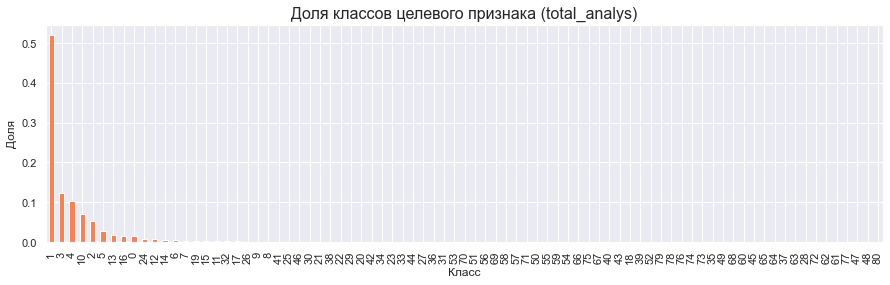

In [59]:
class_balance(df1['total_analys'], 'total_analys')

In [60]:
# посмотрим детально классы менее 5-ти объектами
count_in_kategory = df1.pivot_table(index='total_analys', aggfunc='count')['gender'].sort_values(ascending=False)

In [61]:
small_group = count_in_kategory[count_in_kategory<5]
name_small_group = []
for num in small_group.index:
    name_small_group.append(dict_kategory_rev[num])
len(name_small_group)

37

In [62]:
# названия малочисленных групп
name_small_group

['diabet_2/0/pechen/pochki/0',
 'diabet_2/0/pechen_serdze/pochki/0',
 '0/anemia_3/0/pochki/0',
 'gipoglikemia/anemia_1/pechen/0/0',
 '0/anemia_3/pechen_serdze/0/0',
 'diabet_1/0/pechen/pochki/0',
 'gipoglikemia/anemia_3/pechen/0/0',
 'diabet_2/anemia_1/pechen_serdze/pochki/0',
 'diabet_2/0/pechen/0/tromboz',
 'diabet_2/0/0/pochki/tromboz',
 'diabet_1/anemia_1/pechen_serdze/0/0',
 'diabet_1/anemia_1/pechen/0/0',
 'gipoglikemia/0/0/pochki/0',
 'diabet_1/0/0/pochki/tromboz',
 'gipoglikemia/anemia_1/pechen_serdze/0/0',
 '0/anemia_2/0/pochki/0',
 '0/anemia_3/pechen_serdze/pochki/0',
 'diabet_2/anemia_1/pechen_serdze/0/0',
 'diabet_1/0/pechen/pochki/tromboz',
 'diabet_2/0/pechen_serdze/pochki/tromboz',
 '0/anemia_2/pechen_serdze/0/0',
 '0/anemia_1/pechen/pochki/0',
 '0/anemia_1/pechen_serdze/pochki/0',
 'gipoglikemia/0/pechen/pochki/0',
 'diabet_1/0/pechen_serdze/pochki/tromboz',
 'diabet_2/anemia_2/0/0/0',
 'gipoglikemia/0/pechen/0/tromboz',
 'diabet_1/anemia_1/pechen_serdze/pochki/0',
 'gi

In [63]:
# создадим список объектов, относящихся к малочисленным классам
delete_group = []
for row in df1.index:    
    if df1['total_analys'][row] in small_group.index:
        delete_group.append(row)

Классы с менее чем 5-ю объектами будем рассматривать, как исключения, так как они в основном содержат комбинацию рекомендаций с отклонениями по всем группам диагнозов одновременно. Удалим их из датафрейма, так как они вызовут ошибку при разделении данных на выборки.

In [64]:
df1_clean = df1.drop(labels = delete_group, axis = 0)

In [65]:
df1_clean.head(10)

,gender,age_group,alt_high_norm,ast_high_norm,bilirubin_obschiy_high_norm,gematokrit_high_norm,gematokrit_low_norm,gemoglobin_high_norm,gemoglobin_low_norm,glik_gemoglobin_high_norm,glyukoza_high_norm,glyukoza_low_norm,kreatinin_high_norm,mochevina_high_norm,rdw_high_norm,rdw_low_norm,msn_high_norm,msn_low_norm,mcv_high_norm,mcv_low_norm,msns_high_norm,msns_low_norm,eritrotsity_high_norm,eritrotsity_low_norm,diabet,anemia,pechen_serdce,pochki,tromboz,total_analys
4,0,20_25,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,anemia_2,0,0,0,0
5,1,50_55,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
6,1,20_25,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,anemia_1,0,0,0,2
7,1,35_40,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,tromboz,3
8,0,30_35,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,gipoglikemia,0,0,0,0,4
9,0,20_25,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,anemia_2,0,0,0,0
10,0,25_30,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,anemia_1,0,0,0,2
11,0,5_10,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,tromboz,3
12,0,40_45,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,pechen,0,0,5
13,0,45_50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,diabet_2,0,0,0,0,6


Количество строк в данных по классам (total_analys): [  574 20972  2162  4966  4124  1124   161   149    44    51  2832    94
   290   753   229   123   626    57     0   127    17    24    22    12
   330    34    53     8     0    21    32     8    64    12    13     0
     8     0    23     0     0    34    15     0     9     0    34     0
     0     0     0     6     0     7     0     0     6     0     0     0
     0     0     0     0     0     0     0     0     0     5     7]
1     0.520888
3     0.123342
4     0.102429
10    0.070339
2     0.053698
5     0.027917
13    0.018702
16    0.015548
0     0.014257
24    0.008196
12    0.007203
14    0.005688
6     0.003999
7     0.003701
19    0.003154
15    0.003055
11    0.002335
32    0.001590
17    0.001416
26    0.001316
9     0.001267
8     0.001093
41    0.000844
25    0.000844
46    0.000844
30    0.000795
21    0.000596
38    0.000571
22    0.000546
29    0.000522
20    0.000422
42    0.000373
34    0.000323
23    0.000298
33  

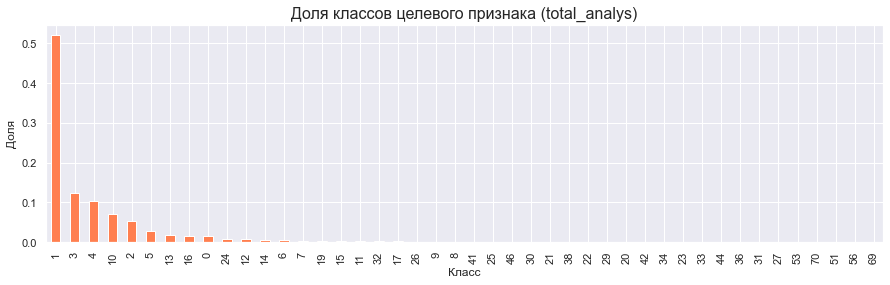

In [66]:
class_balance(df1_clean['total_analys'], 'total_analys')

Самая многочисленная группа - без дополнительных рекомендаций (не выявлено отклонений в выделеных показателях).

Наиболее популярные группы рекомендаций:

In [67]:
print('1. Тромбоз', dict_kategory_rev[3])
print('2. Гипогликемия (пониженный уровень сахара в крови)', dict_kategory_rev[4])
print('3. Дообследование на предмет диабета (повышенный уровень сахара в крови)', dict_kategory_rev[10])
print('4. Железодефицитная анемия', dict_kategory_rev[2])

1. Тромбоз 0/0/0/0/tromboz
2. Гипогликемия (пониженный уровень сахара в крови) gipoglikemia/0/0/0/0
3. Дообследование на предмет диабета (повышенный уровень сахара в крови) diabet_1/0/0/0/0
4. Железодефицитная анемия 0/anemia_1/0/0/0


Целевой признак несбалансирован по классам. Так как нашей целью является предсказание именно малочисленных классов, то применим при обучении модели балансировку классов.

Далее определим метрики качества для моделей на которые будем ориентироваться и подберем наиболее качественную модель для наших целей.

### Определение приоритетных метрик качества для моделей

Для того, чтобы корректно оценить значимость той или иной метрики качества модели необходимо четко понимать цели компании, в частности медицинской лаборатории. В данном случае важно не только не пропустить отклонения в анализах пациента, но и не перегрузить его лишней диагностикой, поэтому, нам важна как метрика полноты (recall) так и точности (precision). 

Так как метрика accuracy не объективна при дисбалансе классов, а у нас именно такая ситуация, то воспользуемся дополнительными метриками для оценки качества модели:
- **f1-мера** - метрика позволяет оценить баланс между полнотой (recall) и precision (точность определения целевого класса). Будем использовать f1_weighted для мультиклассовой модели.
- **auc_roc** - ROC-кривая учитывает не только результаты классификации, но и вероятность предсказания всех классов - насколько хорошо разделяются случаи в разных группах. Будем использовать roc_auc_ovr для многоклассовых данных.

Отслеживание одновременно f1-меру (обращая внимание на precision и recall) и auc_roc подберем оптимальную модель для рекомендации дополнительной лабораторной диагностики.


### Разделение данных на выборки

In [68]:
# разделение данных для обучения модели
features_total = df1_clean.drop(['diabet','anemia','pechen_serdce','pochki','tromboz', 'total_analys'], axis=1)
target_total = df1_clean['total_analys']

#### Деление на выборки и проверка их пропорциональности

In [69]:
SEED = 12345

In [70]:
def split(features, target):
    ''' делит признаки и таргет (со стратификацией) на выборки (train, valid, test),
        проверяет пропорции в полученных выборках '''
    features_train, features_valid_t, target_train, target_valid_t = train_test_split(
        features, target, test_size=0.4, random_state=SEED, stratify=target)
    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid_t, target_valid_t, test_size=0.5, random_state=SEED, stratify=target_valid_t)
    print(f'Количество строк в данных по классам: {np.bincount(target)}')
    print(f'доля: {np.bincount(target)/target.count()}')
    print(f'Количество строк в target_train по классам: {np.bincount(target_train)}') 
    print(f'доля: {np.bincount(target_train)/target_train.count()}') 
    print(f'Количество строк в target_valid по классам: {np.bincount(target_valid)}')
    print(f'доля: {np.bincount(target_valid)/target_valid.count()}')
    print(f'Количество строк в target_test по классам: {np.bincount(target_test)}') 
    print(f'доля: {np.bincount(target_test)/target_test.count()}')
    return features_train, features_valid, features_test, target_train, target_valid, target_test

In [71]:
features_train_t, features_valid_t, features_test_t, target_train_t, target_valid_t, target_test_t = \
split(features_total, target_total)

Количество строк в данных по классам: [  574 20972  2162  4966  4124  1124   161   149    44    51  2832    94
   290   753   229   123   626    57     0   127    17    24    22    12
   330    34    53     8     0    21    32     8    64    12    13     0
     8     0    23     0     0    34    15     0     9     0    34     0
     0     0     0     6     0     7     0     0     6     0     0     0
     0     0     0     0     0     0     0     0     0     5     7]
доля: [1.42566191e-02 5.20888182e-01 5.36982763e-02 1.23342109e-01
 1.02429089e-01 2.79171427e-02 3.99880781e-03 3.70076002e-03
 1.09284189e-03 1.26670309e-03 7.03392777e-02 2.33470766e-03
 7.20282152e-03 1.87024986e-02 5.68774527e-03 3.05498982e-03
 1.55481596e-02 1.41572699e-03 0.00000000e+00 3.15433908e-03
 4.22234365e-04 5.96095574e-04 5.46420943e-04 2.98047787e-04
 8.19631414e-03 8.44468730e-04 1.31637773e-03 1.98698525e-04
 0.00000000e+00 5.21583627e-04 7.94794099e-04 1.98698525e-04
 1.58958820e-03 2.98047787e-04 3.22

В выделенных таргетах распределение соответствует исходным данным.

#### Оценка важности признаков

Далее построим гистограмму, которая показывает важность каждого признака. Это позволит определить наиболее важные характеристики, а также наименее важные - их можно будет исключить из машинного обучения, чтобы улучшить качество модели.

In [72]:
def importances_feature(features_train, target_train):
    ''' строит графики важности признаков для дерева решений и случайного леса'''
    tree = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')
    tree.fit(features_train, target_train) 
    forest = RandomForestClassifier(random_state=SEED, class_weight='balanced')
    forest.fit(features_train, target_train)

    f, ax = plt.subplots(1, 2, figsize=(20, 7))
    ax[0].set_xlabel("признаки")
    ax[0].set_ylabel("важность признаков")
    ax[0].set_title( "Важность признаков (дерево решений)", fontsize=18)
    ax[0].barh(features_train.columns, tree.feature_importances_, color = 'palegreen')
    ax[1].set_xlabel("признаки")
    ax[1].set_title("Важность признаков (случайный лес)", fontsize=18)
    ax[1].barh(features_train.columns, forest.feature_importances_, color = 'lightblue')
    plt.show()

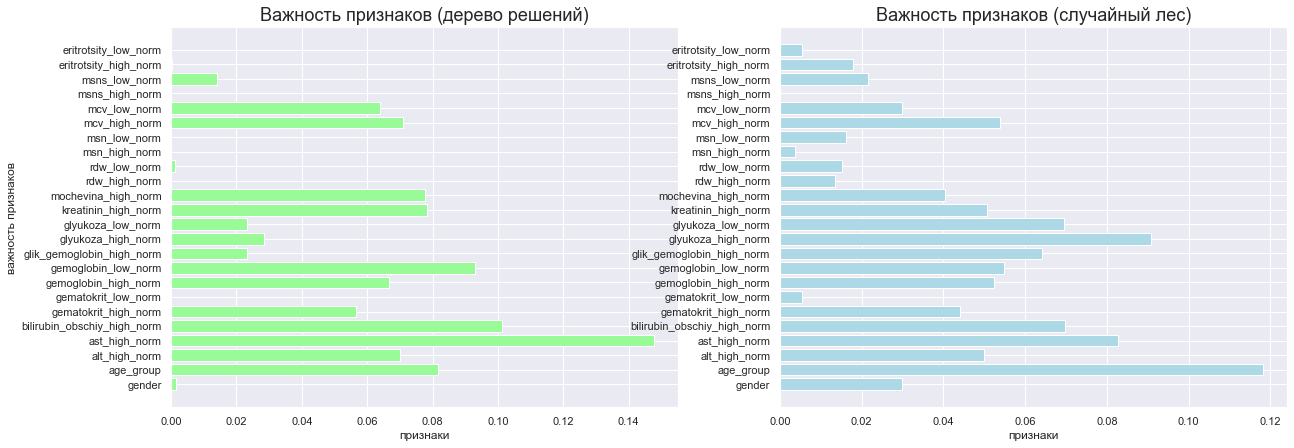

In [73]:
importances_feature(features_train_t, target_train_t)

Из графика видно, что чуть большеполовины признаков оказывают влияние на целевой признак. Пока удалять признаки с незначительным весом не будем, но если результат предсказания будет низким, то рассмотрим их исключение из модели.

На целевой признак в модели случайного леса влияние оказывают практически все факторы.
Удаление признаков с низким влиянием рассмотрим, если качество модели будет низким.

## Построение и тестирование модели

### Обучение моделей

#### Функции для обучения моделей

Напишем функции, которые позволят не дублировать аналогичные операции для различных моделей.

In [74]:
# создадим функции для подбора параметров
# целевой метрикой качества выберем f1
def gridsearch (model, params, features_train, target_train):
    '''подбирает гиперпараметры к модели с помощью GridSearchCV'''
    grid = GridSearchCV(model, params, n_jobs=-1, scoring='f1_weighted', cv=5)
    grid.fit(features_train, target_train)
    print('Лучшие параметры модели:', grid.best_params_)
    print(f'{model}','f1_weighted: {:.2f}'.format(grid.best_score_))
    return grid

In [75]:
# создаем функцию для расчета метрик на обучающей и валидационной выборках, создания матрицы ошибок
def metric_matrix(model_grid, features_train, target_train, features_valid, target_valid):
    '''выводит отчет о метриках качества и строит матрицу ошибок по конкретной модели'''
    model = model_grid
    model.fit(features_train, target_train)
    predictions_train = model.predict(features_train) # получим предсказание
    print('Метрики качества на обучающей выборке')
    print(classification_report(target_train, predictions_train))
    print('roc_auc_ovo', roc_auc_score(target_train, model.predict_proba(features_train), multi_class='ovr'))
    print('f1', f1_score(target_train, model.predict(features_train), average='weighted'))
    print('------------------------------------------------------')
    predictions_valid = model.predict(features_valid)
    print('Метрики качества на валидационной выборке')
    print(classification_report(target_valid, predictions_valid))
    print('roc_auc_ovr', roc_auc_score(target_valid, model.predict_proba(features_valid), multi_class='ovr'))
    print('f1', f1_score(target_valid, model.predict(features_valid), average='weighted'))

#### Подбор гиперпараметров моделей и создание константной модели

Для подбора параметров воспользуемся GridSearch.

Cоздадим параметры, которые будут использованы для подбора.

In [76]:
# гиперпараметры для разных моделей
lr_params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear']}

tree_params = {'max_depth':range(5,50,5),
              'min_samples_leaf':range (2,11,2),
              'min_samples_split':range(2,11,2)}

forest_params = {'n_estimators': range(10,60,5),
                   'max_depth':range(5,21,2),
                   'min_samples_leaf':range (2,9,2),
                   'min_samples_split':range(2,11,2)}

boosting_params = {'learning_rate': [0.01,0.015, 0.02],
                      'max_depth'    : [3,10,20,50]}

Перед тем, как мы начнем обучение моделей, создадим константную модель (dummy), которая всегда предсказывает наиболее часто встречающийся класс. Это позволит проводить сравнительную оценку метрик качества моделей.

In [77]:
# создаем и обучаем константную модель
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(features_train_t, target_train_t)
predictions_valid = dummy_clf.predict(features_valid_t)
result_valid = roc_auc_score(target_valid_t, dummy_clf.predict_proba(features_valid_t), multi_class='ovr') 
result_valid_f = f1_score(target_valid_t, predictions_valid, average='weighted')
print('roc_auc_ovr константной модели на валидационной выборке:',result_valid)
print('f1-мера константной модели на валидационной выборке:',result_valid_f)

roc_auc_ovr константной модели на валидационной выборке: 0.5
f1-мера константной модели на валидационной выборке: 0.3567704092920758


Метрики качества очень низкие. Посмотрим на результаты при обучении реальных моделей.

#### HistGradientBoostingClassifier

In [78]:
# поставим фильтр на ошибки, которые будут возникать при подборе параметров (малочисленный класс для валидации, 
# противоречие penalty и solver и т.д.)
import warnings
warnings.filterwarnings("ignore")

In [79]:
#HistGradientBoostingClassifier 
# grid_boosting_total = gridsearch(HistGradientBoostingClassifier(random_state=SEED), boosting_params, 
#                                      features_train_t, target_train_t)

Для экономии времени загрузки модели с лучшими параметрами, сохраним параметры и полученную модель в переменные.

In [80]:
grid_boosting_total = HistGradientBoostingClassifier(random_state=SEED, learning_rate=0.015, max_depth=10)

In [81]:
metric_matrix(grid_boosting_total, features_train_t, target_train_t, features_valid_t, target_valid_t)

Метрики качества на обучающей выборке
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00     12583
           2       0.99      1.00      1.00      1297
           3       1.00      1.00      1.00      2980
           4       0.99      1.00      1.00      2474
           5       0.99      0.99      0.99       674
           6       0.95      0.92      0.93        97
           7       0.94      0.92      0.93        89
           8       0.92      0.88      0.90        26
           9       0.89      0.77      0.83        31
          10       1.00      1.00      1.00      1699
          11       0.98      0.98      0.98        56
          12       0.99      1.00      0.99       174
          13       1.00      1.00      1.00       452
          14       1.00      1.00      1.00       137
          15       1.00      1.00      1.00        74
          16       1.00      0.99      1.00

#### RandomForestClassifier 

In [82]:
# RandomForestClassifier
# grid_forest_total = gridsearch (RandomForestClassifier(class_weight='balanced', random_state=SEED), 
#                                   forest_params, features_train_t, target_train_t)

Для экономии времени загрузки модели с лучшими параметрами, сохраним параметры и полученную модель в переменные.

In [83]:
grid_forest_total_best_params = {'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

In [84]:
grid_forest_total = RandomForestClassifier(random_state=SEED, max_depth=13, min_samples_leaf=2, min_samples_split=2, 
                             n_estimators=50, class_weight='balanced')

In [85]:
metric_matrix(grid_forest_total, features_train_t, target_train_t, features_valid_t, target_valid_t)

Метрики качества на обучающей выборке
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00     12583
           2       1.00      1.00      1.00      1297
           3       1.00      1.00      1.00      2980
           4       1.00      1.00      1.00      2474
           5       1.00      0.99      1.00       674
           6       1.00      1.00      1.00        97
           7       1.00      1.00      1.00        89
           8       1.00      1.00      1.00        26
           9       1.00      1.00      1.00        31
          10       1.00      1.00      1.00      1699
          11       1.00      1.00      1.00        56
          12       0.99      0.99      0.99       174
          13       1.00      1.00      1.00       452
          14       1.00      1.00      1.00       137
          15       1.00      1.00      1.00        74
          16       1.00      1.00      1.00

#### DecisionTreeClassifier и BaggingClassifier

In [86]:
# DecisionTreeClassifier и BaggingClassifier
# grid_tree_total = gridsearch (DecisionTreeClassifier(class_weight='balanced', random_state=SEED), 
#                           tree_params, features_train_t, target_train_t)

Для экономии времени загрузки модели с лучшими параметрами, сохраним параметры и полученную модель в переменные.

In [87]:
grid_tree_total_best_params = {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [88]:
grid_tree_total = DecisionTreeClassifier(random_state=SEED, max_depth=20, min_samples_leaf=2, min_samples_split=2, 
                                         class_weight='balanced')

In [89]:
bagging_tree = BaggingClassifier(grid_tree_total, n_estimators=100, random_state=SEED)

Применим вариант гиперпараметров на обучающей и валидационной выборках и оценим качество модели.

In [90]:
metric_matrix(bagging_tree, features_train_t, target_train_t, features_valid_t, target_valid_t)

Метрики качества на обучающей выборке
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00     12583
           2       1.00      1.00      1.00      1297
           3       1.00      1.00      1.00      2980
           4       1.00      0.99      1.00      2474
           5       1.00      1.00      1.00       674
           6       1.00      0.99      0.99        97
           7       0.99      0.99      0.99        89
           8       0.87      1.00      0.93        26
           9       1.00      0.90      0.95        31
          10       1.00      1.00      1.00      1699
          11       1.00      0.96      0.98        56
          12       0.99      1.00      1.00       174
          13       1.00      1.00      1.00       452
          14       1.00      1.00      1.00       137
          15       1.00      1.00      1.00        74
          16       1.00      1.00      1.00

#### LogisticRegression

In [91]:
# LogisticRegression
# grid_log_total = gridsearch(LogisticRegression(class_weight='balanced', random_state=SEED), 
#                           lr_params, features_train_t, target_train_t)

Лучшие параметры модели: {'penalty': 'none', 'solver': 'newton-cg'}
LogisticRegression(class_weight='balanced', random_state=12345) f1_weighted: 1.00


Для экономии времени загрузки модели с лучшими параметрами, сохраним параметры и полученную модель в переменные.

In [92]:
grid_log_total = LogisticRegression(random_state=SEED, penalty = 'none', solver='newton-cg', class_weight='balanced')

Применим вариант гиперпараметров на обучающей и валидационной выборках и оценим качество модели.

In [93]:
metric_matrix(grid_log_total, features_train_t, target_train_t, features_valid_t, target_valid_t)

Метрики качества на обучающей выборке
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00     12583
           2       1.00      1.00      1.00      1297
           3       1.00      1.00      1.00      2980
           4       1.00      1.00      1.00      2474
           5       1.00      1.00      1.00       674
           6       1.00      1.00      1.00        97
           7       1.00      1.00      1.00        89
           8       1.00      1.00      1.00        26
           9       1.00      1.00      1.00        31
          10       1.00      1.00      1.00      1699
          11       1.00      1.00      1.00        56
          12       0.92      1.00      0.96       174
          13       1.00      1.00      1.00       452
          14       1.00      1.00      1.00       137
          15       1.00      1.00      1.00        74
          16       1.00      1.00      1.00

#### Выводы по результатам подбора гиперпараметров различных моделей

Модели после подбора гиперпараметров с помощью GridSearch показали следующие результаты целевых метрик качества на валидационной выборке:

Модель                                      | F1-мера              | roc_auc_ovr        | 
-------------------------------             | -------------------- | ------------------ |
HistGradientBoostingClassifier()            | 0.9880024161745189   |  0.8979784982105137
RandomForestClassifier()                    | 0.995900919299452    |  0.9999208357025825   
DecisionTreeClassifier & BaggingClassifier()| 0.996128149488036    |  0.9999494697243289      
**LogisticRegression()**                    | 0.9979791594456238   |  0.9999606957324537     

Лучшие метрики показала модель LogisticRegression().

Далее проверим полученные модели с помощью кросс-валидации - посмотрим на медианные значения метрик качества и стандартные отклонения результатов.

### Оценка моделей с помощью кросс-валидации

Кросс-валидацию проведем с оценкой по метрике f1.

In [94]:
%%time
num_folds = 10
grid_models = {}
grid_models['Boosting'] = grid_boosting_total
grid_models['Forest'] = grid_forest_total
grid_models['Bagging_tree'] = bagging_tree
grid_models['LR'] = grid_log_total

results_f1 = []
print('f1')
for key in grid_models:
    kfold = KFold(n_splits=num_folds, random_state=SEED, shuffle=True)
    cv_result = cross_val_score(grid_models[key], features_valid_t, target_valid_t, cv=kfold, scoring='f1_weighted')
    results_f1.append(cv_result)
    print('%s: %f (%f)' % (key, cv_result.mean(), cv_result.std()))

f1
Boosting: 0.971695 (0.003228)
Forest: 0.988550 (0.002658)
Bagging_tree: 0.989918 (0.002443)
LR: 0.992335 (0.002238)
CPU times: total: 30min 12s
Wall time: 12min 32s


In [95]:
def graf_model(results, models, name):
    '''строит боксплоты по результатам обучения моделей с метрикой f1'''
    fig = plt.figure(figsize=(17, 7))
    fig.suptitle(f'Результаты обученных моделей по предсказанию {name}')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(models.keys())
    plt.show()

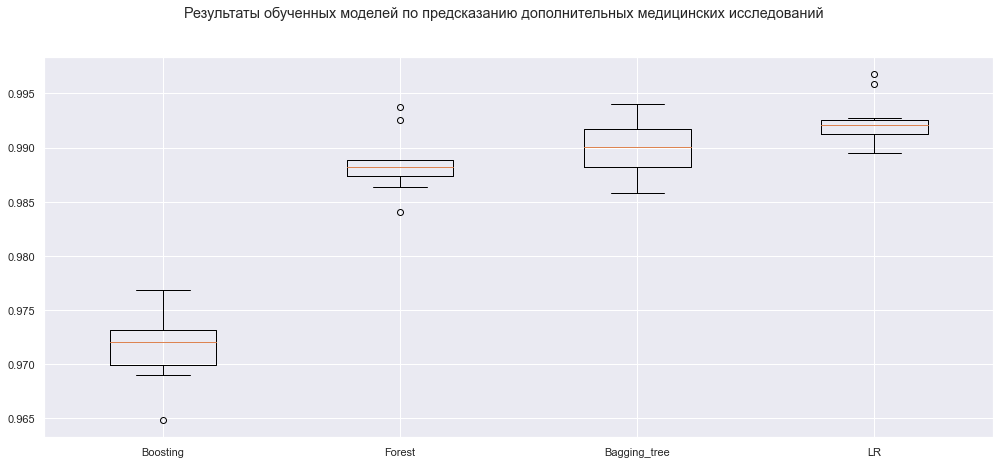

In [96]:
graf_model(results_f1, grid_models, 'дополнительных медицинских исследований')

Из диаграммы видно, что лучший результат по предсказанию дополнительной лабораторной диагностики показывает модель LogisticRegression c максимальным значением метрики f1 и минимальным стандартным отклонением из всех проверяемых моделей (f1 = 0.99, стандартное отклонение = 0.002).

Используем ее для тестирования.

#### Тестирование выбранной модели

In [97]:
predictions_test = grid_log_total.predict(features_test_t)
result_test = roc_auc_score(target_test_t, grid_log_total.predict_proba(features_test_t), multi_class='ovr') 
result_test_f = f1_score(target_test_t, predictions_test, average='weighted')
print('roc_auc_ovr модели логистической регрессии на тестовой выборке:',result_test)
print('f1-мера модели логистической регрессии на тестовой выборке:',result_test_f)
print(classification_report(target_test_t, predictions_test))

roc_auc_ovr модели логистической регрессии на тестовой выборке: 0.9998995750398088
f1-мера модели логистической регрессии на тестовой выборке: 0.996696795068579
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       115
           1       1.00      1.00      1.00      4195
           2       1.00      1.00      1.00       433
           3       1.00      1.00      1.00       993
           4       1.00      1.00      1.00       825
           5       1.00      1.00      1.00       225
           6       1.00      1.00      1.00        32
           7       0.97      1.00      0.98        30
           8       1.00      0.89      0.94         9
           9       0.90      0.90      0.90        10
          10       1.00      1.00      1.00       567
          11       1.00      1.00      1.00        19
          12       0.87      1.00      0.93        58
          13       1.00      1.00      1.00       151
          14       1.00     

Обученная модель показывает отличные результаты - практически 1 по метрикам f1 и roc_auc. Это значительно превышает результаты предсказания константной модели.

Параметры полученной модели:

LogisticRegression(random_state=12345, penalty = 'none', solver='newton-cg', class_weight='balanced')

## Создание графического интерфейса (GUI) для предсказания рекомендаций

Для создания GUI будем использовать библиотеки joblib, tkinter и customtkinter.

In [109]:
features_test_t.columns

Index(['gender', 'age_group', 'alt_high_norm', 'ast_high_norm',
       'bilirubin_obschiy_high_norm', 'gematokrit_high_norm',
       'gematokrit_low_norm', 'gemoglobin_high_norm', 'gemoglobin_low_norm',
       'glik_gemoglobin_high_norm', 'glyukoza_high_norm', 'glyukoza_low_norm',
       'kreatinin_high_norm', 'mochevina_high_norm', 'rdw_high_norm',
       'rdw_low_norm', 'msn_high_norm', 'msn_low_norm', 'mcv_high_norm',
       'mcv_low_norm', 'msns_high_norm', 'msns_low_norm',
       'eritrotsity_high_norm', 'eritrotsity_low_norm'],
      dtype='object')

Сохраним модель в отдельный файл, чтобы можно было ее использовать не только в текущем проекте. Это позволит создать в дальнейшем отдельный ноутбук, чтобы использовать именно GUI, без подробностей обучения модели.

In [103]:
jbl.dump(grid_log_total, 'model_joblib')

['model_joblib']

In [104]:
 loaded_model_jbl = jbl.load('model_joblib')

Проверим, что результаты предсказания не изменились в загруженной модели:

In [105]:
predictions_test =  loaded_model_jbl.predict(features_test_t)
result_test = roc_auc_score(target_test_t,  loaded_model_jbl.predict_proba(features_test_t), multi_class='ovr') 
result_test_f = f1_score(target_test_t, predictions_test, average='weighted')
print('roc_auc_ovr модели логистической регрессии на тестовой выборке:',result_test)
print('f1-мера модели логистической регрессии на тестовой выборке:',result_test_f)
print(classification_report(target_test_t, predictions_test))

roc_auc_ovr модели логистической регрессии на тестовой выборке: 0.9998995750398088
f1-мера модели логистической регрессии на тестовой выборке: 0.996696795068579
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       115
           1       1.00      1.00      1.00      4195
           2       1.00      1.00      1.00       433
           3       1.00      1.00      1.00       993
           4       1.00      1.00      1.00       825
           5       1.00      1.00      1.00       225
           6       1.00      1.00      1.00        32
           7       0.97      1.00      0.98        30
           8       1.00      0.89      0.94         9
           9       0.90      0.90      0.90        10
          10       1.00      1.00      1.00       567
          11       1.00      1.00      1.00        19
          12       0.87      1.00      0.93        58
          13       1.00      1.00      1.00       151
          14       1.00     

Результаты тестирования аналогичны предыдущим.

Теперь создадим непосредственно графический интерфейс.

In [106]:
# создадим словари
norm_gui = {'норма': 'norm', 'повышен': 'high_norm', 'понижен': 'low_norm'}
gender_gui = {'мужской': 1, 'женский': 0}

In [107]:
# создаем алгоритм обработки данных из полей интерфейса
def prognoz():
    row_gui = pd.DataFrame(0, index=np.arange(1), columns=features_test_t.columns)
    row_gui.loc[0,['gender']] = gender_gui.get(combobox_gender.get())
    row_gui.loc[0,['age_group']] = dict_age.get(age_box.get())
    if alt_size.get() == "повышен":
        row_gui.loc[0,['alt_high_norm']] = 1
    if ast_size.get() == "повышен":
        row_gui.loc[0,['ast_high_norm']] = 1
    if bilirubin_obschiy_size.get() == "повышен":
        row_gui.loc[0,['bilirubin_obschiy_high_norm']] = 1    
    if  gematokrit_size.get() == "повышен":
        row_gui.loc[0,['gematokrit_high_norm']] = 1
    if  gematokrit_size.get() == "понижен":
        row_gui.loc[0,['gematokrit_low_norm']] = 1        
    if  gemoglobin_size.get() == "повышен":
        row_gui.loc[0,['gemoglobin_high_norm']] = 1
    if  gemoglobin_size.get() == "понижен":
        row_gui.loc[0,['gemoglobin_low_norm']] = 1        
    if  glik_gemoglobin_size.get() == "повышен":
        row_gui.loc[0,['glik_gemoglobin_high_norm']] = 1
    if  glyukoza_size.get() == "повышен":
        row_gui.loc[0,['glyukoza_high_norm']] = 1
    if  glyukoza_size.get() == "понижен":
        row_gui.loc[0,['glyukoza_low_norm']] = 1        
    if  kreatinin_size.get() == "повышен":
        row_gui.loc[0,['kreatinin_high_norm']] = 1
    if  mochevina_size.get() == "повышен":
        row_gui.loc[0,['mochevina_high_norm']] = 1
    if  rdw_size.get() == "повышен":
        row_gui.loc[0,['rdw_high_norm']] = 1
    if  rdw_size.get() == "понижен":
        row_gui.loc[0,['rdw_low_norm']] = 1    
    if  msn_size.get() == "повышен":
        row_gui.loc[0,['msn_high_norm']] = 1
    if  msn_size.get() == "понижен":
        row_gui.loc[0,['msn_low_norm']] = 1  
    if  mcv_size.get() == "повышен":
        row_gui.loc[0,['mcv_high_norm']] = 1
    if  mcv_size.get() == "понижен":
        row_gui.loc[0,['mcv_low_norm']] = 1      
    if  msns_size.get() == "повышен":
        row_gui.loc[0,['msns_high_norm']] = 1
    if  msns_size.get() == "понижен":
        row_gui.loc[0,['msns_low_norm']] = 1     
    if  eritrotsity_size.get() == "повышен":
        row_gui.loc[0,['eritrotsity_high_norm']] = 1
    if  eritrotsity_size.get() == "понижен":
        row_gui.loc[0,['eritrotsity_low_norm']] = 1  
    
    predict_gui = loaded_model_pkl.predict(row_gui)
    text = []
    for diagnoz in dict_diagnoz.keys():
        if  diagnoz in (str(dict_kategory_rev.get(int(predict_gui)))).split(sep='/'):
            text.append(dict_diagnoz.get(diagnoz))
            textbox.delete("1.0", "end")
            textbox.insert("0.0", text)
    if text == []:
        text.append('Рекомендации по дополнительным медицинским анализам отсутствуют')
    text = str(text).replace(',','\n\n')
    textbox.delete("1.0", "end")
    textbox.insert("0.0", str(text))


In [108]:
# создаем интерфейс
customtkinter.set_appearance_mode("light")  # Modes: system (default), light, dark
customtkinter.set_default_color_theme("blue")

app = customtkinter.CTk()
app.geometry("850x750") 
app.title('Рекомендации по дополнительной лабораторной диагностике') 

title_app = customtkinter.CTkLabel(master=app, text="Внесите информации об отклонениях в анализе крови", justify=customtkinter.LEFT)
title_app.pack(pady=20, padx=10)
title_app.place(x=30, y=3)



#__________________________________________________________________________
# name gender
gender_name = customtkinter.CTkLabel(master=app, text="Пол", justify=customtkinter.LEFT)
gender_name.pack(pady=20, padx=10)
gender_name.place(x=30, y=30)

# gender
combobox_gender_var = customtkinter.StringVar()  
def combobox_callback(choice):
    print("combobox dropdown clicked:", choice)

combobox_gender = customtkinter.CTkComboBox(master=app,
                                     values=["мужской", "женский"],
                                     command=combobox_callback,
                                     variable=combobox_gender_var)
combobox_gender.pack(padx=20, pady=10)
combobox_gender.place(x=200, y=30)
#__________________________________________________________________________
# name age
age_name = customtkinter.CTkLabel(master=app, text="Возраст", justify=customtkinter.LEFT)
age_name.pack(pady=20, padx=10)
age_name.place(x=30, y=70)

# age
age_box_var = customtkinter.StringVar()  
age_box = customtkinter.CTkComboBox(master=app,
                                     values=['от  20 до 25 лет', 'от  50 до 55 лет', 'от  35 до 40 лет',
                                            'от  30 до 35 лет', 'от  25 до 30 лет', 'от   5 до 10 лет',
                                            'от  40 до 45 лет', 'от  45 до 50 лет', 'от  10 до 15 лет',
                                            'от  65 до 70 лет', 'от  15 до 20 лет', 'от  55 до 60 лет',
                                            'от  70 до 75 лет', 'от   0 до 5 лет', 'от  60 до 65 лет',
                                            'от  75 до 80 лет', 'от  80 до 85 лет', 'от  90 до 95 лет',
                                            'от  85 до 90 лет', 'от  95 до 100 лет'],
                                     command=combobox_callback,
                                     variable=age_box_var)
age_box.pack(padx=20, pady=10)
age_box.place(x=200, y=70)
#________________________________________________________________________

# тесты
# АЛТ
alt = customtkinter.CTkLabel(master=app, text="АЛТ", justify=customtkinter.LEFT)
alt.pack(pady=10, padx=10)
alt.place(x=30, y=110)
alt_size_var = customtkinter.StringVar(value='норма')  
alt_size = customtkinter.CTkSegmentedButton(master=app,
                                                     values=["понижен", "норма", "повышен"],
                                                     variable=alt_size_var)
alt_size.pack(padx=20, pady=10)
alt_size.place(x=200, y=110)
#____________________________________________________________________
# АСТ
ast = customtkinter.CTkLabel(master=app, text="АСТ", justify=customtkinter.LEFT)
ast.pack(pady=10, padx=10)
ast.place(x=30, y=150)
ast_size_var = customtkinter.StringVar(value='норма') 
ast_size = customtkinter.CTkSegmentedButton(master=app,
                                                     values=["понижен", "норма", "повышен"],
                                                     variable=ast_size_var)
ast_size.pack(padx=20, pady=10)
ast_size.place(x=200, y=150)
#____________________________________________________________________
# Билирубин общий
bilirubin_obschiy = customtkinter.CTkLabel(master=app, text="Билирубин общий", justify=customtkinter.LEFT)
bilirubin_obschiy.pack(pady=10, padx=10)
bilirubin_obschiy.place(x=30, y=190)
bilirubin_obschiy_var = customtkinter.StringVar(value='норма')  
bilirubin_obschiy_size = customtkinter.CTkSegmentedButton(master=app,
                                                     values=["понижен", "норма", "повышен"],
                                                     variable=bilirubin_obschiy_var)
bilirubin_obschiy_size.pack(padx=20, pady=10)
bilirubin_obschiy_size.place(x=200, y=190)
#____________________________________________________________________
# Гематокрит
gematokrit = customtkinter.CTkLabel(master=app, text="Гематокрит", justify=customtkinter.LEFT)
gematokrit.pack(pady=10, padx=10)
gematokrit.place(x=30, y=230)
gematokrit_var = customtkinter.StringVar(value='норма')  
gematokrit_size = customtkinter.CTkSegmentedButton(master=app,
                                                     values=["понижен", "норма", "повышен"],
                                                     variable=gematokrit_var)
gematokrit_size.pack(padx=20, pady=10)
gematokrit_size.place(x=200, y=230)
#____________________________________________________________________
# Гемоглобин
gemoglobin = customtkinter.CTkLabel(master=app, text="Гемоглобин", justify=customtkinter.LEFT)
gemoglobin.pack(pady=10, padx=10)
gemoglobin.place(x=30, y=270)
gemoglobin_var = customtkinter.StringVar(value='норма')  
gemoglobin_size = customtkinter.CTkSegmentedButton(master=app,
                                                     values=["понижен", "норма", "повышен"],
                                                     variable=gemoglobin_var)
gemoglobin_size.pack(padx=20, pady=10)
gemoglobin_size.place(x=200, y=270)
#____________________________________________________________________
# Гликированный гемоглобин
glik_gemoglobin = customtkinter.CTkLabel(master=app, text="Гликированный гемоглобин", justify=customtkinter.LEFT)
glik_gemoglobin.pack(pady=10, padx=10)
glik_gemoglobin.place(x=30, y=310)
glik_gemoglobin_var = customtkinter.StringVar(value='норма')  
glik_gemoglobin_size = customtkinter.CTkSegmentedButton(master=app,
                                                     values=["понижен", "норма", "повышен"],
                                                     variable=glik_gemoglobin_var)
glik_gemoglobin_size.pack(padx=20, pady=10)
glik_gemoglobin_size.place(x=200, y=310)
#____________________________________________________________________
# Глюкоза
glyukoza = customtkinter.CTkLabel(master=app, text="Глюкоза", justify=customtkinter.LEFT)
glyukoza.pack(pady=10, padx=10)
glyukoza.place(x=30, y=350)
glyukoza_var = customtkinter.StringVar(value='норма')  
glyukoza_size = customtkinter.CTkSegmentedButton(master=app,
                                                     values=["понижен", "норма", "повышен"],
                                                     variable=glyukoza_var)
glyukoza_size.pack(padx=20, pady=10)
glyukoza_size.place(x=200, y=350)
#____________________________________________________________________
# Креатинин
kreatinin = customtkinter.CTkLabel(master=app, text="Креатинин", justify=customtkinter.LEFT)
kreatinin.pack(pady=10, padx=10)
kreatinin.place(x=30, y=390)
kreatinin_var = customtkinter.StringVar(value='норма') 
kreatinin_size = customtkinter.CTkSegmentedButton(master=app,
                                                     values=["понижен", "норма", "повышен"],
                                                     variable=kreatinin_var)
kreatinin_size.pack(padx=20, pady=10)
kreatinin_size.place(x=200, y=390)
#____________________________________________________________________
# Мочевина
mochevina = customtkinter.CTkLabel(master=app, text="Мочевина", justify=customtkinter.LEFT)
mochevina.pack(pady=10, padx=10)
mochevina.place(x=30, y=430)
mochevina_var = customtkinter.StringVar(value='норма')  
mochevina_size = customtkinter.CTkSegmentedButton(master=app,
                                                     values=["понижен", "норма", "повышен"],
                                                     variable=mochevina_var)
mochevina_size.pack(padx=20, pady=10)
mochevina_size.place(x=200, y=430)
#____________________________________________________________________
# RDW
rdw = customtkinter.CTkLabel(master=app, text="RDW", justify=customtkinter.LEFT)
rdw.pack(pady=10, padx=10)
rdw.place(x=30, y=470)
rdw_var = customtkinter.StringVar(value='норма') 
rdw_size = customtkinter.CTkSegmentedButton(master=app,
                                                     values=["понижен", "норма", "повышен"],
                                                     variable=rdw_var)
rdw_size.pack(padx=20, pady=10)
rdw_size.place(x=200, y=470)
#____________________________________________________________________
# MSN
msn = customtkinter.CTkLabel(master=app, text="MSN", justify=customtkinter.LEFT)
msn.pack(pady=10, padx=10)
msn.place(x=30, y=510)
msn_var = customtkinter.StringVar(value='норма')  
msn_size = customtkinter.CTkSegmentedButton(master=app,
                                                     values=["понижен", "норма", "повышен"],
                                                     variable=msn_var)
msn_size.pack(padx=20, pady=10)
msn_size.place(x=200, y=510)
#____________________________________________________________________
# MCV
mcv = customtkinter.CTkLabel(master=app, text="MCV", justify=customtkinter.LEFT)
mcv.pack(pady=10, padx=10)
mcv.place(x=30, y=550)
mcv_var = customtkinter.StringVar(value='норма')  
mcv_size = customtkinter.CTkSegmentedButton(master=app,
                                                     values=["понижен", "норма", "повышен"],
                                                     variable=mcv_var)
mcv_size.pack(padx=20, pady=10)
mcv_size.place(x=200, y=550)
#____________________________________________________________________
# MSNS
msns = customtkinter.CTkLabel(master=app, text="MSNS", justify=customtkinter.LEFT)
msns.pack(pady=10, padx=10)
msns.place(x=30, y=590)
msns_var = customtkinter.StringVar(value='норма') 
msns_size = customtkinter.CTkSegmentedButton(master=app,
                                                     values=["понижен", "норма", "повышен"],
                                                     variable=msns_var)
msns_size.pack(padx=20, pady=10)
msns_size.place(x=200, y=590)
#____________________________________________________________________
# Эритроциты
eritrotsity = customtkinter.CTkLabel(master=app, text="Эритроциты", justify=customtkinter.LEFT)
eritrotsity.pack(pady=10, padx=10)
eritrotsity.place(x=30, y=630)
eritrotsity_var = customtkinter.StringVar(value='норма') 
eritrotsity_size = customtkinter.CTkSegmentedButton(master=app,
                                                     values=["понижен", "норма", "повышен"],
                                                     variable=eritrotsity_var)
eritrotsity_size.pack(padx=20, pady=10)
eritrotsity_size.place(x=200, y=630)
#____________________________________________________________________


text_name = customtkinter.CTkLabel(master=app, text="'Рекомендуем проверить следующие показатели \n\n для комплексной оценки \
состояния Вашего здоровья \n\n и исключения сопутствующих заболеваний:'", 
                                 justify=customtkinter.LEFT)
text_name.pack(pady=20, padx=10)
text_name.place(x=400, y=30)
textbox = customtkinter.CTkTextbox(app, width=400, height=400)
textbox.place(x=400, y=110)

info = customtkinter.CTkLabel(master=app, text="Обращаем внимание, что при верном и своевременно поставленном \n\n диагнозе лечение выявленных заболеваний протекает быстро \n\n и успешно, позволяет избежать серьезных осложнений. \n\n Указанный перечень анализов носит рекомендательных характер. \n\n Необходимо проконсультироваться с Вашим лечащим врачом.", justify=customtkinter.LEFT)
info.pack(pady=20, padx=10)
info.place(x=400, y=550)

button = customtkinter.CTkButton(master=app, text="Отправить данные", command= prognoz)
button.place(x=250, y=670)
 
app.mainloop()

combobox dropdown clicked: мужской
combobox dropdown clicked: от  45 до 50 лет


Графический интерфейс реализован.

## Выводы по результатам проекта

**В ходе проекта были выполнены следующие этапы:**

- Проведена предобработка данных и подготовка их к построению модели.
- Проведен подбор гиперпараметров и проверка моделей кросс-валидацией.
- Обучены и оценены результаты следующих моделей: 

Модель                                      | F1-мера              | roc_auc_ovr        | 
-------------------------------             | -------------------- | ------------------ |
HistGradientBoostingClassifier()            | 0.9880024161745189   |  0.8979784982105137
RandomForestClassifier()                    | 0.995900919299452    |  0.9999208357025825   
DecisionTreeClassifier & BaggingClassifier()| 0.996128149488036    |  0.9999494697243289      
**LogisticRegression()**                    | 0.9979791594456238   |  0.9999606957324537     

Лучшие метрики показала модель LogisticRegression().


По результатам кросс-валидации выбрана **модель LogisticRegression** c максимальным значением метрики f1 и минимальным стандартным отклонением из всех проверяемых моделей (f1 = 0.99, стандартное отклонение = 0.002).

Результаты лучшей модели на тестовой выборке:
roc_auc_ovr: 0.999899
f1-мера : 0.996697

Параметры полученной модели:

**LogisticRegression(random_state=12345, penalty = 'none', solver='newton-cg', class_weight='balanced')**

- реализован графический интерфейс для работы с предсказанием модели.


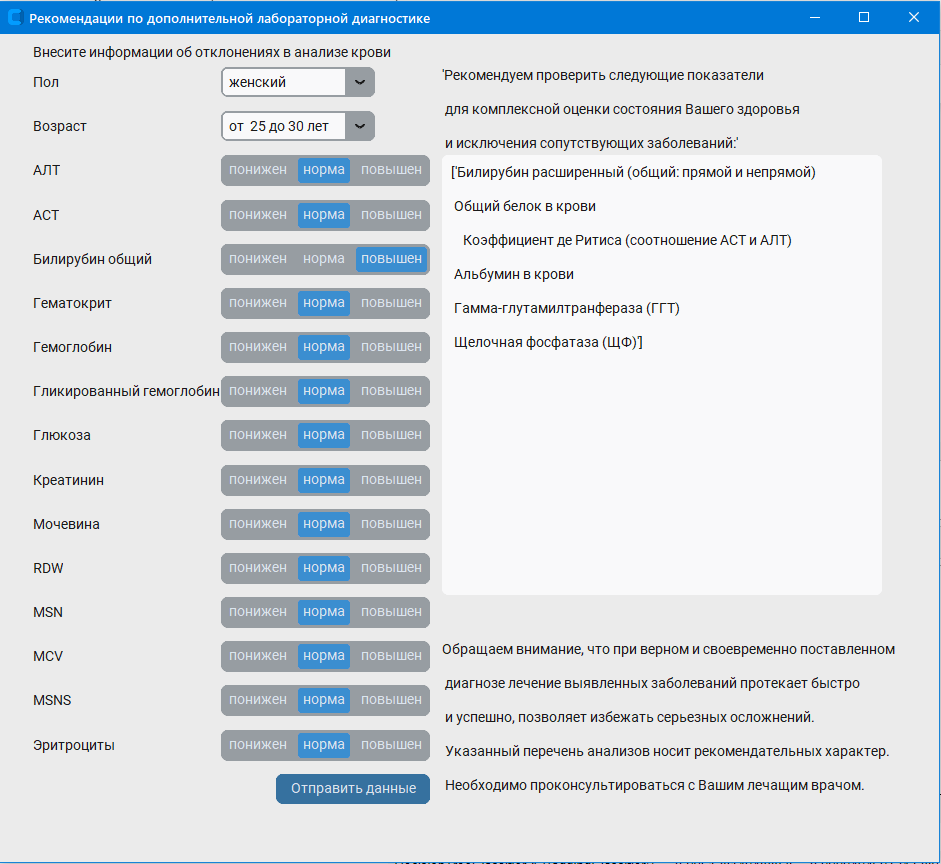